In [3]:
import spacy
import requests
import os
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
def get_fileNames(category: str):
    file_names = []
    for files in os.listdir("Data/" + category):
        if files.endswith(".csv"):
            files = files[0:len(files)-4]
            file_names.append(files)
    return file_names

In [7]:
def get_text(article: str, url="https://en.wikipedia.org/wiki/"):
    soup = BeautifulSoup(requests.get(url + article).text, "lxml")
    tags = soup.find_all("p")
    text = ""

    for i in tags:
        text += i.text

    return text

def get_similarity(article1: str, article2: str):
    nlp = spacy.load("en_core_web_lg")
    doc1 = nlp(get_text(article1))
    doc2 = nlp(get_text(article2))
    return doc1.similarity(doc2)

In [8]:
files = get_fileNames("Music")

pairs = [(a,b) for a in files for b in files]

#for article1, article2 in pairs:
    #s = get_similarity(article1, article2)
    #if s < 0.9:
    #    print(f"{get_similarity(article1, article2)} = {article1} <=> {article2}")

In [9]:
nlp = spacy.load("en_core_web_lg")
def most_common_propn(article: str, count: int, pos="PROPN"):
    doc = nlp(get_text(article))

    propn = [token.text for token in doc if token.is_alpha and not token.is_stop and token.pos_ == pos]
    return Counter(propn).most_common(count)

In [10]:
files = get_fileNames("Games")

#for file in files:
#    print(f"{file}: {most_common_propn(file, 5)}")

In [11]:
files = get_fileNames("Music")

#for file in files:
#    print(f"{file}: {most_common_propn(file, 5)}")

In [12]:
def smape(target, forecast):
    if type(target) == pd.core.frame.DataFrame:
        target = target.values

    denominator = np.abs(target) + np.abs(forecast)
    flag = denominator == 0.

    smape = 2 * np.mean(
        (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
    )
    return smape

# Moving Average

In [13]:
from sklearn.preprocessing import StandardScaler

def moving_average(path, days_avg, days_to_predict):
    df = pd.read_csv(path)

    df.index = df["timestamp"]
    df.drop(["project", 'granularity', 'access', 'agent', 'timestamp'], axis=1, inplace=True)
    df.index = pd.to_datetime(df.index)

    df = df.tail(days_avg + days_to_predict)
    df_tmp = df.head(days_avg)

    prediction = []

    for i in df_tmp["views"]:
        prediction.append(i)

    for j in range(days_to_predict):
        prediction.append(sum([prediction[j + i] for i in range(days_avg)]) / days_avg)

    df["predicted"] = prediction
    return df.tail(days_to_predict)

days_to_predict = 14
days_avg = 14
def asdasd():
    for file in get_fileNames("Games"):
        df_views = pd.read_csv(f"Data/Games/{file}.csv")
        df_views.index = df_views["timestamp"]
        df_views.drop(["project", 'granularity', 'access', 'agent', 'timestamp'], axis=1, inplace=True)
        df_views.index = pd.to_datetime(df_views.index)
        df_views["views"].tail(days_to_predict + days_avg).plot()

        df = moving_average(f"Data/Games/{file}.csv", days_avg, days_to_predict)
        print(smape(df["views"], df["predicted"]))
        df["predicted"].plot()

        plt.title(file)
        plt.legend()
        plt.xlabel("Tage")
        plt.ylabel("Pageviews")
        plt.show()



In [14]:
#for file in files:
#    df = moving_average(f"Data/Games/{file}.csv").tail(n)
#    loss = smape(df["views"], df["predicted"])
#    print(f"Article: {file}, loss = {loss}")
def split_train_test(data, perc):
    n = int(len(data) * (1 - perc))
    return data[:n], data[n:]

# XGBoost


In [24]:
import xgboost as xgb
import itertools


def make_data(category, article):
    df = pd.read_csv(f"Data/{category}/{article}.csv")

    df.index = df["timestamp"]
    df.drop(["project", "article", 'granularity', 'access', 'agent', 'timestamp'], axis=1, inplace=True)
    df.index = pd.to_datetime(df.index)

    words = most_common_propn(article, 3)

    dfN = df[["views"]].copy()
    df["target"] = df.views.shift(-1)
    df.dropna(inplace=True)

    df = df.loc[(df.index >= '2015.01.01') & (df.index <= "2021.01.01")]

    return df

In [16]:


#fig, ax = plt.subplots(figsize=(15,5))
#train_data["views"].plot(ax=ax, label="Train")
#test_data["views"].plot(ax=ax, label="Test")
#plt.legend()
#plt.show()

# Features

In [33]:
def create_features(df):
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["dayofyear"] = df.index.dayofyear
    df["year"] = df.index.year
    return df

In [18]:
import seaborn as sns

#fig, ax = plt.subplots(figsize=(15,5))
#sns.boxplot(data=df, x="month", y="views")

In [62]:
FEATURES = ["dayofweek", "month", "quarter", "dayofyear", "year"]
TARGET = "views"
model = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.005, eval_metric=smape)

In [54]:
def train_xgboost(category: str):
    files = get_fileNames(category)
    for file in files:
        df = make_data(category, file)
        train_data, test_data = split_train_test(df, 0.2)

        train_data = create_features(train_data)
        test_data = create_features(test_data)

        X_train = train_data[FEATURES]
        y_train = train_data[TARGET]

        X_test = test_data[FEATURES]
        y_test = test_data[TARGET]

        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1000)
        break

In [50]:
def test_xgboost(category):
    files = get_fileNames(category)
    for file in files:
        if file == "The World Ends With You":
            continue
        df = make_data(category, file)
        _, test_data = split_train_test(df, 0.2)

        test_data = create_features(test_data)

        X_test = test_data[FEATURES]
        y_test = test_data[TARGET]

        test_data["prediction"] = model.predict(X_test)

        test_data = test_data.head(14)

        test_data["views"].plot()
        test_data["prediction"].plot()
        loss = smape(test_data["views"], test_data["prediction"])
        print(f"Loss: {loss}, Game: {file}")
        plt.legend()
        plt.grid()
        plt.show()

In [51]:
train_xgboost("Games")

[0]	validation_0-rmse:386.76728	validation_0-smape:1.97402	validation_1-rmse:313.14312	validation_1-smape:1.97215
[1000]	validation_0-rmse:43.29673	validation_0-smape:0.07354	validation_1-rmse:197.46947	validation_1-smape:0.21621
[1261]	validation_0-rmse:39.94827	validation_0-smape:0.07029	validation_1-rmse:200.67927	validation_1-smape:0.21590


Loss: 0.09126058569171137, Game: Advance Wars


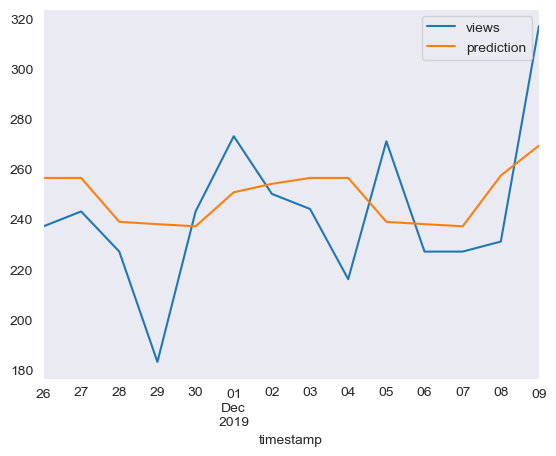

In [52]:
test_xgboost("Games")

[0]	validation_0-rmse:386.76728	validation_0-smape:1.97402	validation_1-rmse:313.14312	validation_1-smape:1.97215
[1000]	validation_0-rmse:43.29673	validation_0-smape:0.07354	validation_1-rmse:197.46947	validation_1-smape:0.21621
[1260]	validation_0-rmse:39.95420	validation_0-smape:0.07030	validation_1-rmse:200.66503	validation_1-smape:0.21590
Loss: 0.09126058569171137, Game: Advance Wars


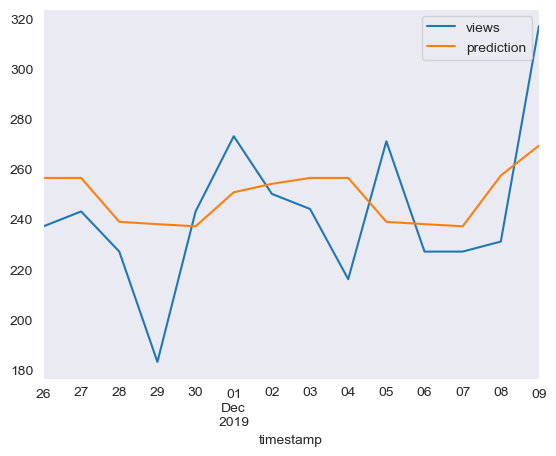

[0]	validation_0-rmse:1718.82207	validation_0-smape:1.97830	validation_1-rmse:894.04852	validation_1-smape:1.96787
[262]	validation_0-rmse:557.64583	validation_0-smape:0.30317	validation_1-rmse:266.50238	validation_1-smape:0.19176
Loss: 0.29190313090833847, Game: Angry Birds


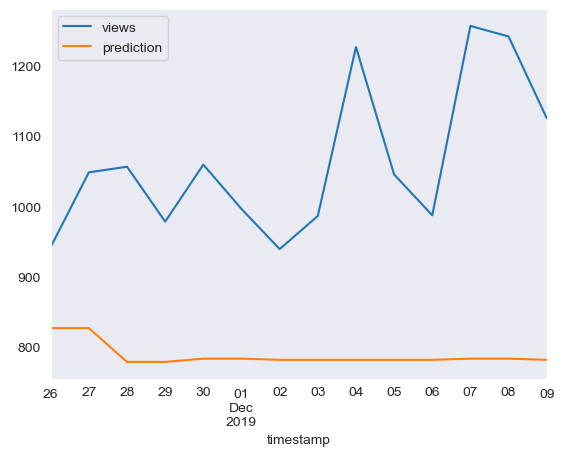

[0]	validation_0-rmse:1329.54229	validation_0-smape:1.97737	validation_1-rmse:11604.14574	validation_1-smape:1.98973
[1000]	validation_0-rmse:148.40103	validation_0-smape:0.07051	validation_1-rmse:10850.63533	validation_1-smape:0.80829
[1488]	validation_0-rmse:115.57298	validation_0-smape:0.06199	validation_1-rmse:10849.92003	validation_1-smape:0.80369
Loss: 0.13822839148618268, Game: Animal Crossing


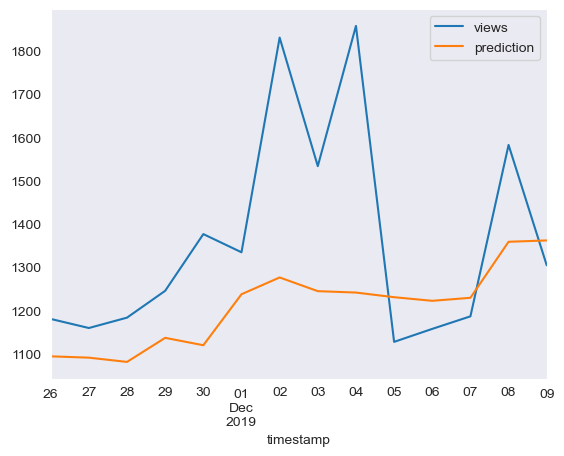

[0]	validation_0-rmse:1221.71919	validation_0-smape:1.97799	validation_1-rmse:1646.69712	validation_1-smape:1.98361
[1000]	validation_0-rmse:131.45651	validation_0-smape:0.06625	validation_1-rmse:975.54726	validation_1-smape:0.38543
[1153]	validation_0-rmse:120.53299	validation_0-smape:0.06254	validation_1-rmse:973.47295	validation_1-smape:0.38441
Loss: 0.03320779751609215, Game: Assassin's Creed II


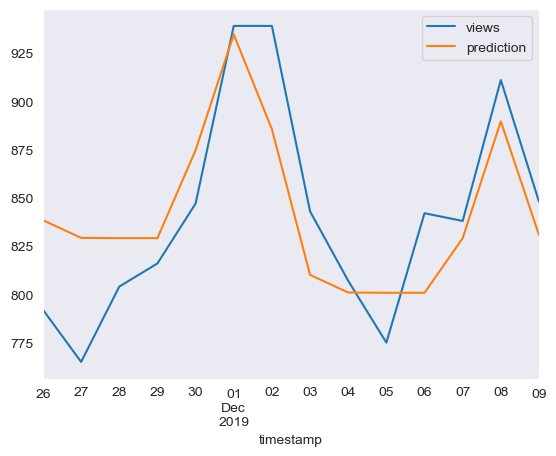

[0]	validation_0-rmse:891.44823	validation_0-smape:1.97448	validation_1-rmse:369.91905	validation_1-smape:1.97616
[972]	validation_0-rmse:80.00833	validation_0-smape:0.07643	validation_1-rmse:132.38789	validation_1-smape:0.24883
Loss: 0.3659937426584588, Game: Battlefield 1942


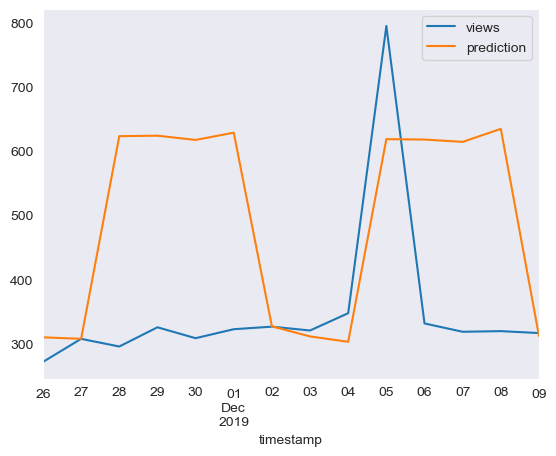

[0]	validation_0-rmse:1681.37446	validation_0-smape:1.97762	validation_1-rmse:1062.65309	validation_1-smape:1.97141
[626]	validation_0-rmse:341.63119	validation_0-smape:0.10862	validation_1-rmse:746.29490	validation_1-smape:0.31700
Loss: 0.2409293962966535, Game: Bayonetta


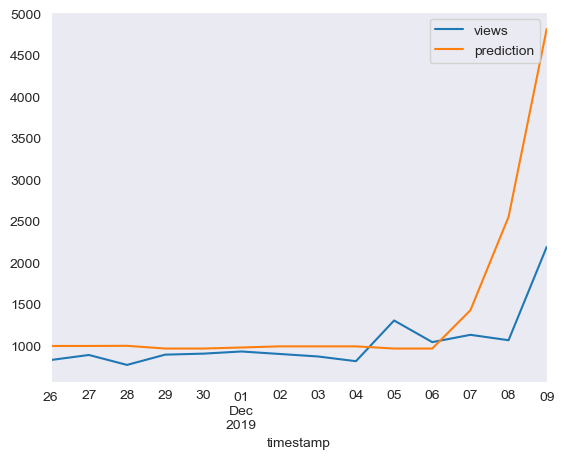

[0]	validation_0-rmse:206.62284	validation_0-smape:1.94026	validation_1-rmse:35.28078	validation_1-smape:1.91808
[480]	validation_0-rmse:60.55241	validation_0-smape:0.14415	validation_1-rmse:10.21611	validation_1-smape:0.21584
Loss: 0.10412201694664706, Game: Beyond Good & Evil


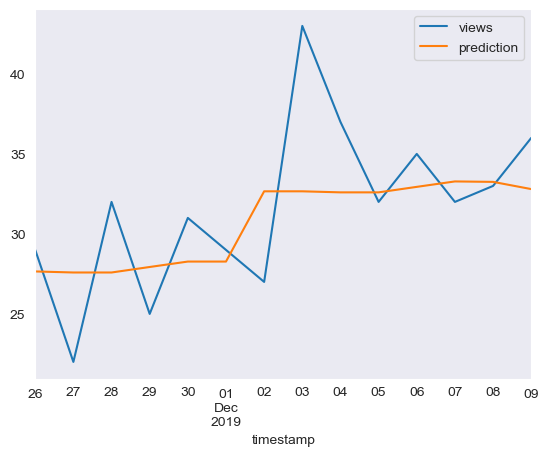

[0]	validation_0-rmse:1645.86186	validation_0-smape:1.97851	validation_1-rmse:1598.42392	validation_1-smape:1.98347
[1000]	validation_0-rmse:148.05381	validation_0-smape:0.05637	validation_1-rmse:646.97864	validation_1-smape:0.32722
[1329]	validation_0-rmse:132.36619	validation_0-smape:0.05201	validation_1-rmse:642.96573	validation_1-smape:0.32495
Loss: 0.16674269098347974, Game: BioShock Infinite


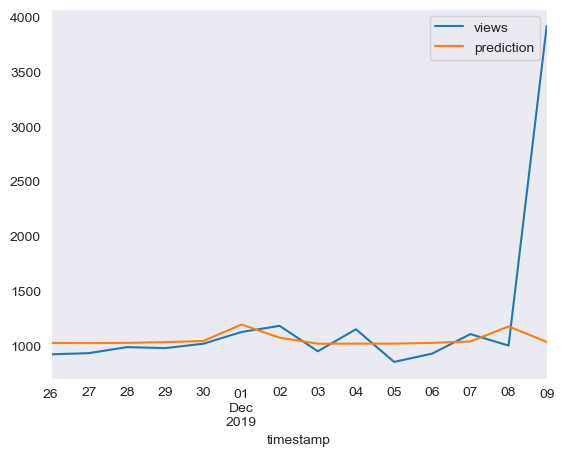

[0]	validation_0-rmse:2028.09608	validation_0-smape:1.97867	validation_1-rmse:2196.69863	validation_1-smape:1.98447
[1000]	validation_0-rmse:214.24647	validation_0-smape:0.05916	validation_1-rmse:920.23627	validation_1-smape:0.36304
[1234]	validation_0-rmse:193.66547	validation_0-smape:0.05554	validation_1-rmse:916.82096	validation_1-smape:0.36134
Loss: 0.16733634734970954, Game: BioShock


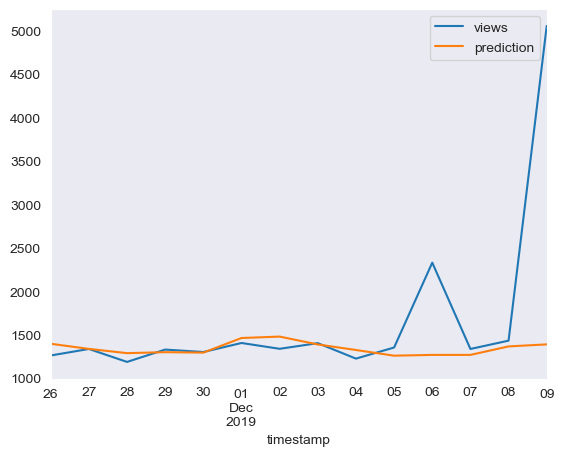

[0]	validation_0-rmse:2910.47721	validation_0-smape:1.97910	validation_1-rmse:2476.56835	validation_1-smape:1.98298
[1000]	validation_0-rmse:241.94266	validation_0-smape:0.05462	validation_1-rmse:892.77732	validation_1-smape:0.31973
[1301]	validation_0-rmse:210.68723	validation_0-smape:0.04910	validation_1-rmse:895.56511	validation_1-smape:0.31747
Loss: 0.20350745124704028, Game: Bloodborne


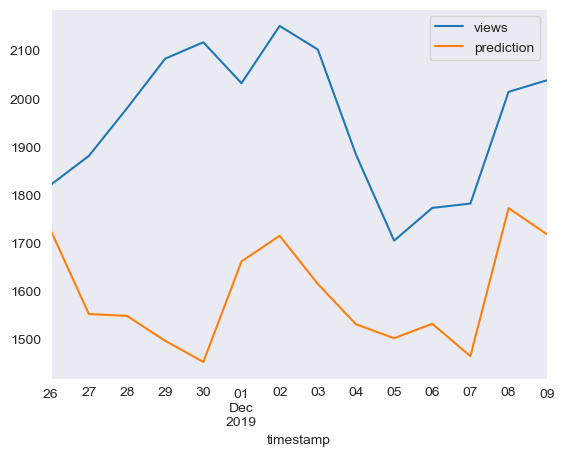

[0]	validation_0-rmse:508.09188	validation_0-smape:1.97564	validation_1-rmse:604.07350	validation_1-smape:1.97938
[1000]	validation_0-rmse:54.72637	validation_0-smape:0.06649	validation_1-rmse:199.46434	validation_1-smape:0.20731
[1162]	validation_0-rmse:52.15423	validation_0-smape:0.06444	validation_1-rmse:199.79651	validation_1-smape:0.20682
Loss: 0.28407704420444446, Game: Braid


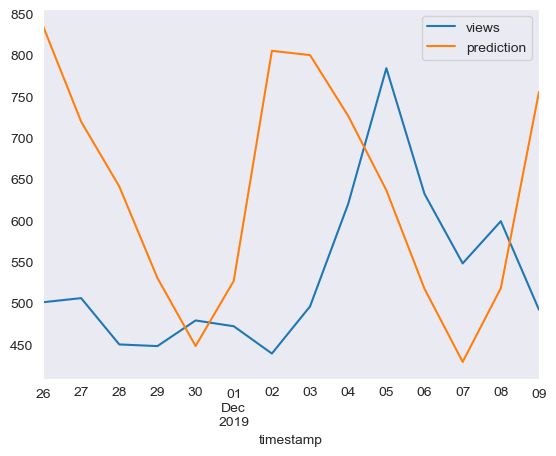

[0]	validation_0-rmse:521.68145	validation_0-smape:1.97471	validation_1-rmse:508.51030	validation_1-smape:1.97802
[956]	validation_0-rmse:53.26160	validation_0-smape:0.07543	validation_1-rmse:223.18553	validation_1-smape:0.30727
Loss: 0.11614508358396804, Game: Burnout Paradise


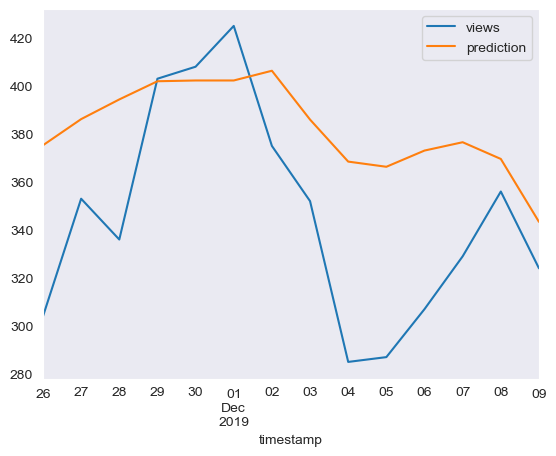

[0]	validation_0-rmse:690.82623	validation_0-smape:1.97653	validation_1-rmse:753.31509	validation_1-smape:1.98105
[1000]	validation_0-rmse:66.09692	validation_0-smape:0.05777	validation_1-rmse:293.75724	validation_1-smape:0.32372
[1243]	validation_0-rmse:60.99553	validation_0-smape:0.05561	validation_1-rmse:292.82934	validation_1-smape:0.32210
Loss: 0.096957291488788, Game: Call of Duty 2


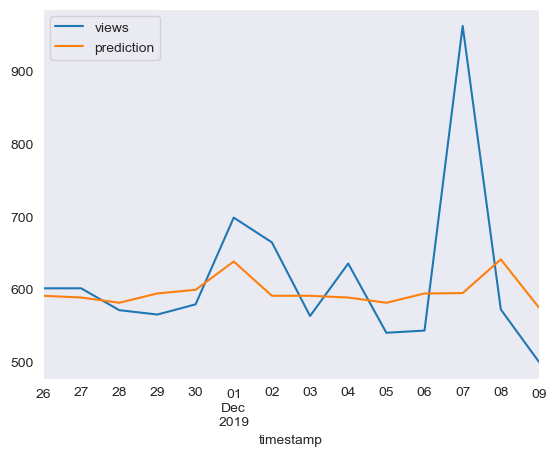

[0]	validation_0-rmse:420.50836	validation_0-smape:1.97451	validation_1-rmse:375.41297	validation_1-smape:1.97480
[1000]	validation_0-rmse:39.57181	validation_0-smape:0.06278	validation_1-rmse:160.95683	validation_1-smape:0.24352
[1025]	validation_0-rmse:39.17340	validation_0-smape:0.06233	validation_1-rmse:160.92042	validation_1-smape:0.24355
Loss: 0.10960695265253942, Game: Civilization IV


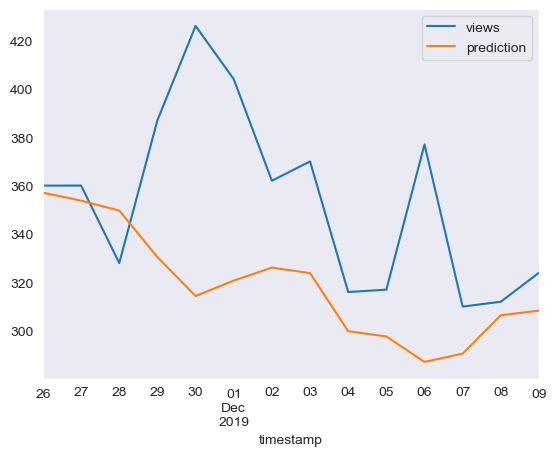

[0]	validation_0-rmse:459.33858	validation_0-smape:1.97472	validation_1-rmse:424.61348	validation_1-smape:1.97878
[1000]	validation_0-rmse:52.99325	validation_0-smape:0.06928	validation_1-rmse:154.34230	validation_1-smape:0.28184
[1308]	validation_0-rmse:46.69313	validation_0-smape:0.06400	validation_1-rmse:154.38773	validation_1-smape:0.28019
Loss: 0.189626825321885, Game: Company of Heroes


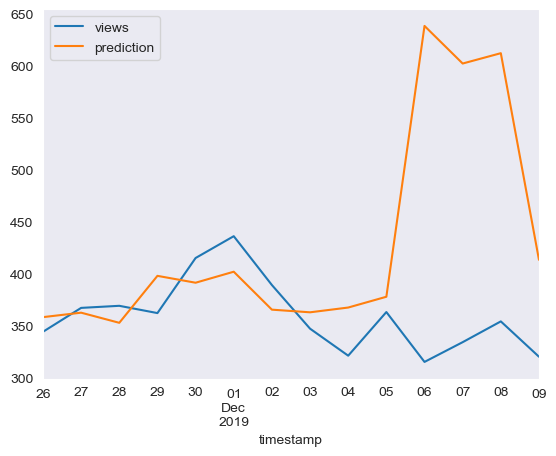

[0]	validation_0-rmse:1617.76829	validation_0-smape:1.97862	validation_1-rmse:1716.65034	validation_1-smape:1.98164
[1000]	validation_0-rmse:110.66700	validation_0-smape:0.04435	validation_1-rmse:628.22685	validation_1-smape:0.24361
[1123]	validation_0-rmse:105.46390	validation_0-smape:0.04302	validation_1-rmse:626.89769	validation_1-smape:0.24323
Loss: 0.1678472597560137, Game: Counter-Strike


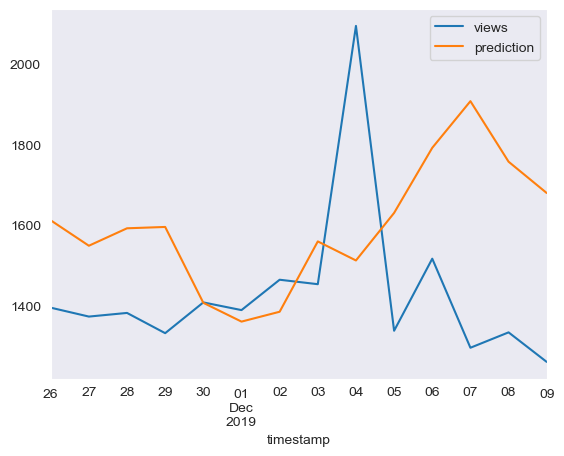

[0]	validation_0-rmse:2958.39429	validation_0-smape:1.97894	validation_1-rmse:2304.78838	validation_1-smape:1.98004
[1000]	validation_0-rmse:233.38430	validation_0-smape:0.05727	validation_1-rmse:799.06992	validation_1-smape:0.23147
[1407]	validation_0-rmse:185.70499	validation_0-smape:0.05059	validation_1-rmse:799.34177	validation_1-smape:0.22994
Loss: 0.10037193540800514, Game: Dark Souls


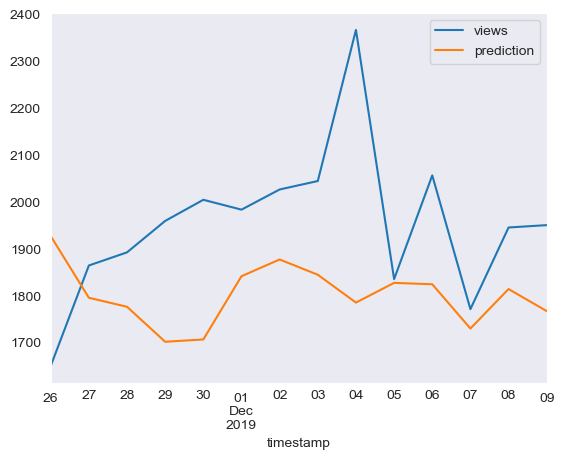

[0]	validation_0-rmse:54.92010	validation_0-smape:1.88526	validation_1-rmse:50.57486	validation_1-smape:1.90263
[208]	validation_0-rmse:22.75348	validation_0-smape:0.41465	validation_1-rmse:27.83494	validation_1-smape:0.42345
Loss: 0.5808482239183953, Game: Dead Space


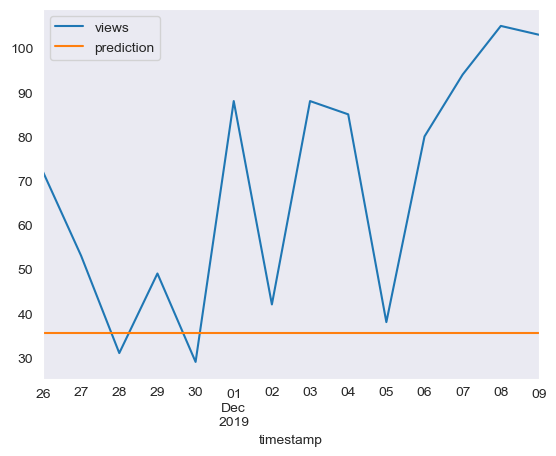

[0]	validation_0-rmse:1078.43973	validation_0-smape:1.97748	validation_1-rmse:5053.93505	validation_1-smape:1.98543
[1000]	validation_0-rmse:91.94300	validation_0-smape:0.06406	validation_1-rmse:4797.53120	validation_1-smape:0.69559
[1196]	validation_0-rmse:83.50435	validation_0-smape:0.06023	validation_1-rmse:4797.05718	validation_1-smape:0.69524
Loss: 0.2455379084489259, Game: Demon's Souls


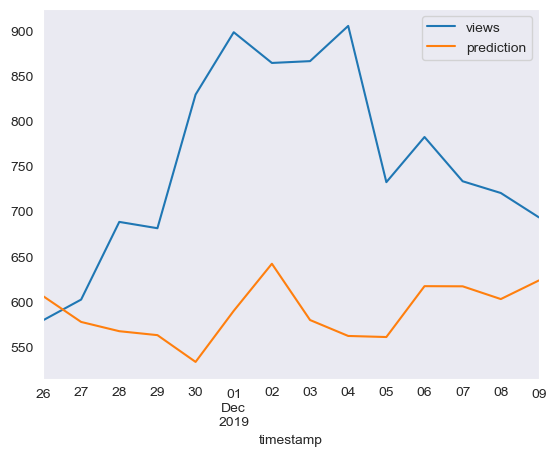

[0]	validation_0-rmse:605.44021	validation_0-smape:1.97648	validation_1-rmse:566.33882	validation_1-smape:1.97689
[903]	validation_0-rmse:56.72336	validation_0-smape:0.06071	validation_1-rmse:91.67973	validation_1-smape:0.10181
Loss: 0.07572912094036054, Game: Destiny


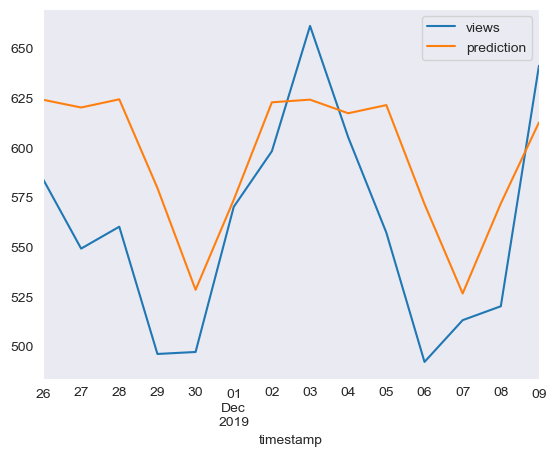

[0]	validation_0-rmse:1456.31915	validation_0-smape:1.97784	validation_1-rmse:1510.05348	validation_1-smape:1.98160
[1000]	validation_0-rmse:123.84153	validation_0-smape:0.06728	validation_1-rmse:952.83340	validation_1-smape:0.32027
[1019]	validation_0-rmse:122.45953	validation_0-smape:0.06674	validation_1-rmse:952.78109	validation_1-smape:0.32017
Loss: 0.08874945985125934, Game: Deus Ex


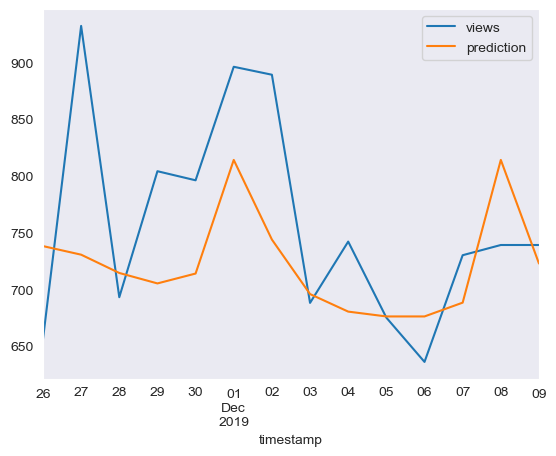

[0]	validation_0-rmse:2270.84045	validation_0-smape:1.97828	validation_1-rmse:1292.92658	validation_1-smape:1.96985
[411]	validation_0-rmse:584.69080	validation_0-smape:0.13559	validation_1-rmse:1512.62694	validation_1-smape:0.33231
Loss: 0.48938182428961374, Game: Devil May Cry


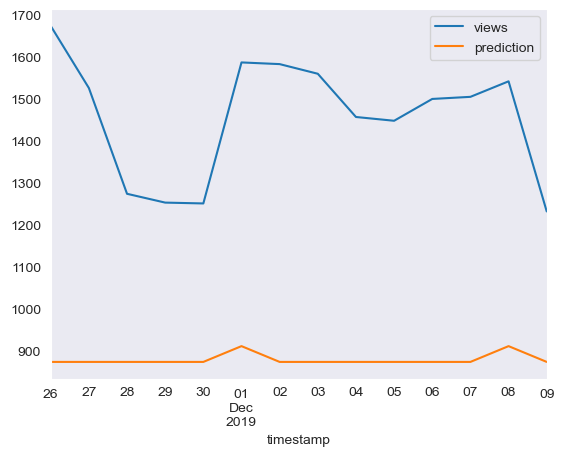

[0]	validation_0-rmse:807.73976	validation_0-smape:1.97653	validation_1-rmse:671.32654	validation_1-smape:1.97471
[1000]	validation_0-rmse:88.77791	validation_0-smape:0.06357	validation_1-rmse:655.33516	validation_1-smape:0.29825
[1080]	validation_0-rmse:83.79098	validation_0-smape:0.06236	validation_1-rmse:661.63870	validation_1-smape:0.29840
Loss: 0.19070820006995323, Game: Diablo II


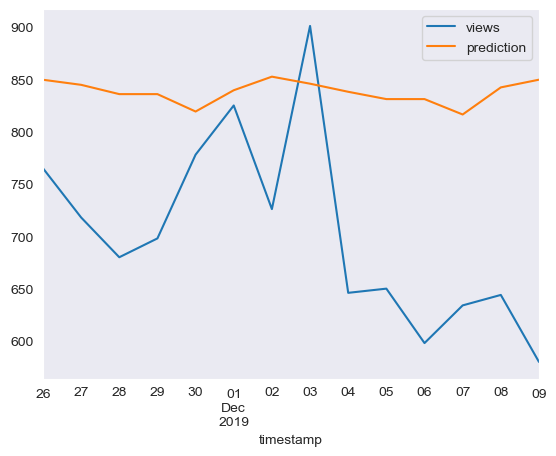

[0]	validation_0-rmse:1963.46416	validation_0-smape:1.97808	validation_1-rmse:1147.15648	validation_1-smape:1.98201
[1000]	validation_0-rmse:221.34105	validation_0-smape:0.07444	validation_1-rmse:377.90299	validation_1-smape:0.24203
[1205]	validation_0-rmse:191.75222	validation_0-smape:0.06968	validation_1-rmse:377.15591	validation_1-smape:0.24031
Loss: 0.08164888629107654, Game: Dishonored


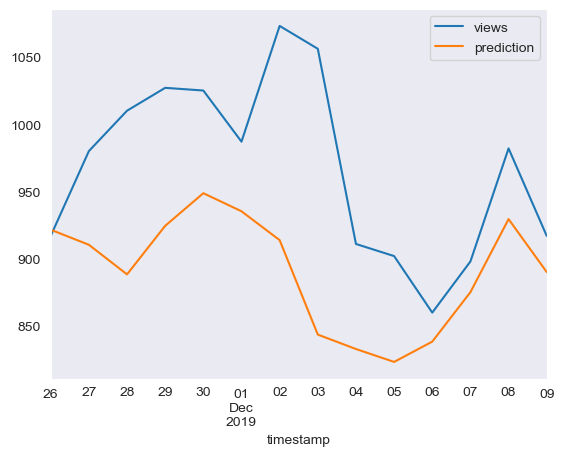

[0]	validation_0-rmse:2918.84818	validation_0-smape:1.97863	validation_1-rmse:1945.33648	validation_1-smape:1.97311
[361]	validation_0-rmse:869.77952	validation_0-smape:0.17461	validation_1-rmse:596.49773	validation_1-smape:0.18351
Loss: 0.28180543343849657, Game: Dota 2


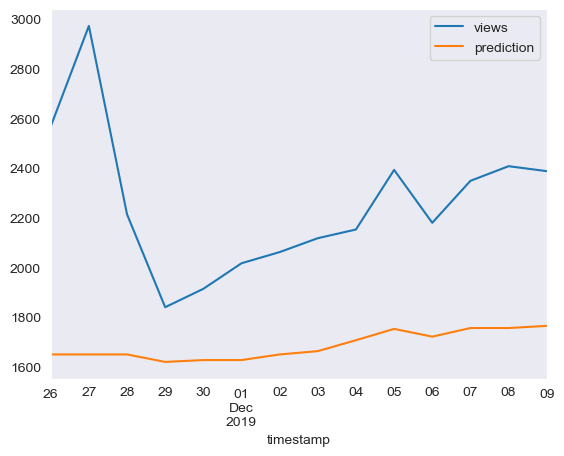

[0]	validation_0-rmse:388.26400	validation_0-smape:1.94664	validation_1-rmse:411.10071	validation_1-smape:1.97540
[725]	validation_0-rmse:67.97844	validation_0-smape:0.12776	validation_1-rmse:209.95279	validation_1-smape:0.41625
Loss: 0.0768246192441352, Game: Dragon Quest VIII


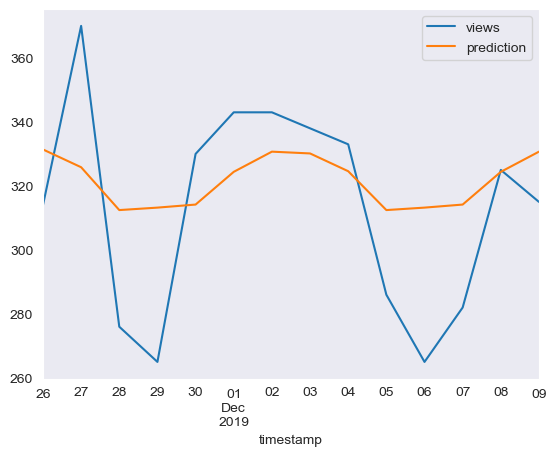

[0]	validation_0-rmse:181.63856	validation_0-smape:1.96748	validation_1-rmse:182.61760	validation_1-smape:1.96899
[826]	validation_0-rmse:34.62020	validation_0-smape:0.10662	validation_1-rmse:67.43073	validation_1-smape:0.23435
Loss: 0.18092610328210018, Game: F-Zero GX


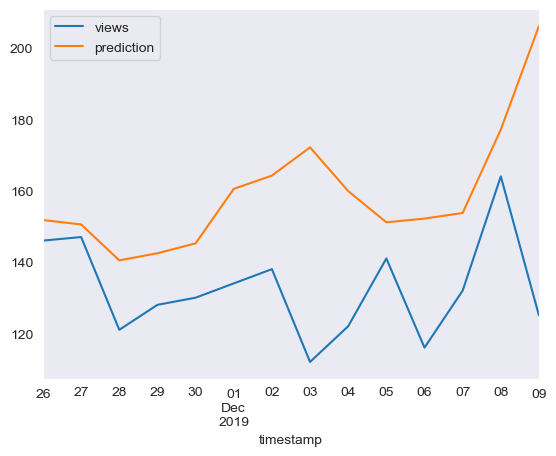

[0]	validation_0-rmse:416.70906	validation_0-smape:1.97470	validation_1-rmse:542.91134	validation_1-smape:1.97802
[1000]	validation_0-rmse:45.38475	validation_0-smape:0.07029	validation_1-rmse:327.55327	validation_1-smape:0.22318
[1080]	validation_0-rmse:43.82157	validation_0-smape:0.06860	validation_1-rmse:327.61098	validation_1-smape:0.22319
Loss: 0.0908495425284858, Game: Fable II


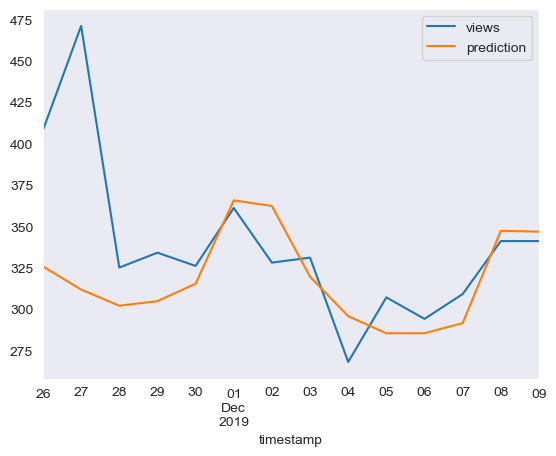

[0]	validation_0-rmse:2936.73244	validation_0-smape:1.97839	validation_1-rmse:1085.27041	validation_1-smape:1.97717
[561]	validation_0-rmse:450.02557	validation_0-smape:0.08445	validation_1-rmse:436.99805	validation_1-smape:0.19971
Loss: 0.19989135589029877, Game: Fallout 3


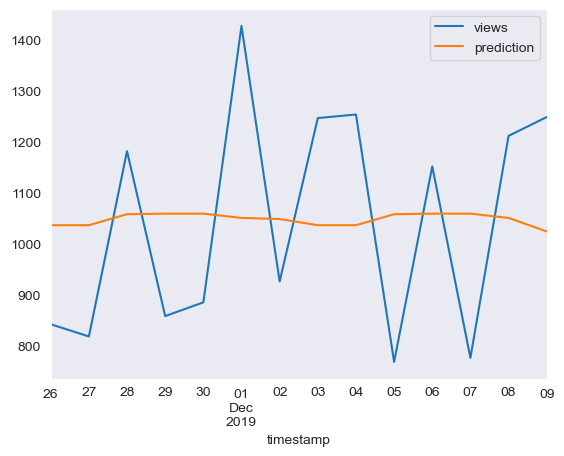

[0]	validation_0-rmse:1319.52375	validation_0-smape:1.97815	validation_1-rmse:1409.40877	validation_1-smape:1.97725
[746]	validation_0-rmse:135.49611	validation_0-smape:0.06381	validation_1-rmse:860.21766	validation_1-smape:0.24509
Loss: 0.1874724924197753, Game: Far Cry 3


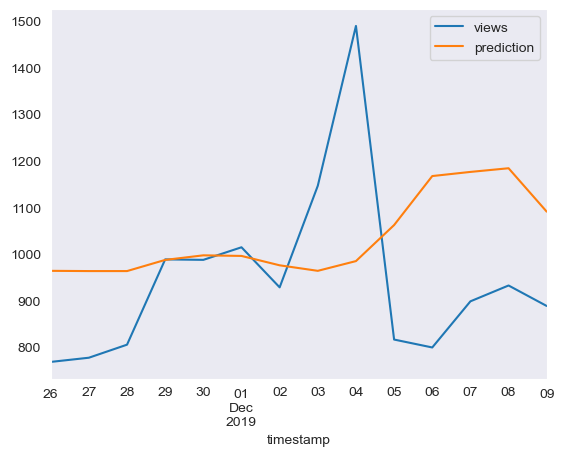

[0]	validation_0-rmse:1205.30237	validation_0-smape:1.97802	validation_1-rmse:1345.90984	validation_1-smape:1.97760
[692]	validation_0-rmse:165.57762	validation_0-smape:0.07037	validation_1-rmse:556.94276	validation_1-smape:0.22765
Loss: 0.09646422906694486, Game: Final Fantasy X


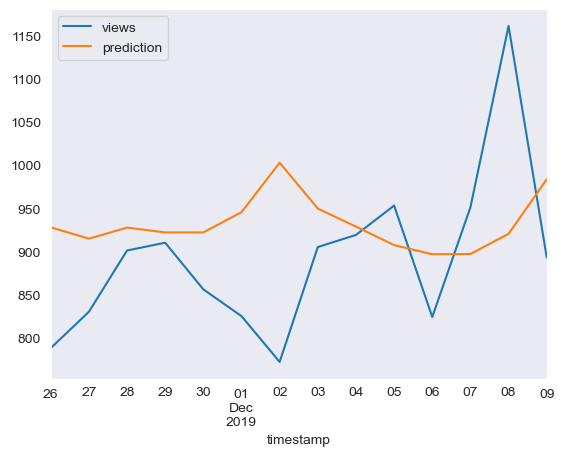

[0]	validation_0-rmse:387.20219	validation_0-smape:1.97211	validation_1-rmse:277.10332	validation_1-smape:1.96469
[714]	validation_0-rmse:44.47554	validation_0-smape:0.07922	validation_1-rmse:352.13772	validation_1-smape:0.36741
Loss: 0.10756350169486696, Game: Gears of War 2


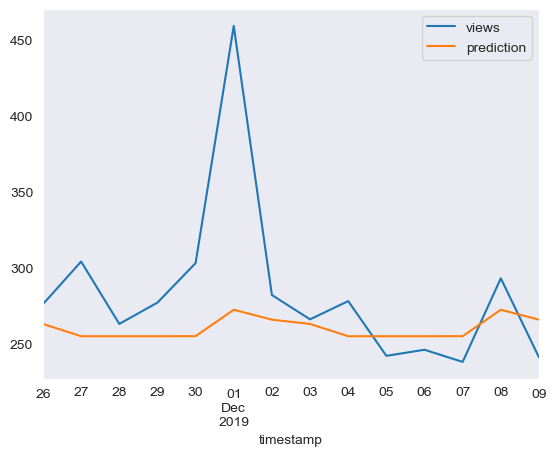

[0]	validation_0-rmse:1892.56661	validation_0-smape:1.97829	validation_1-rmse:1407.22454	validation_1-smape:1.97272
[527]	validation_0-rmse:285.62084	validation_0-smape:0.08921	validation_1-rmse:1345.17850	validation_1-smape:0.34290
Loss: 0.08125918478389738, Game: Gears of War


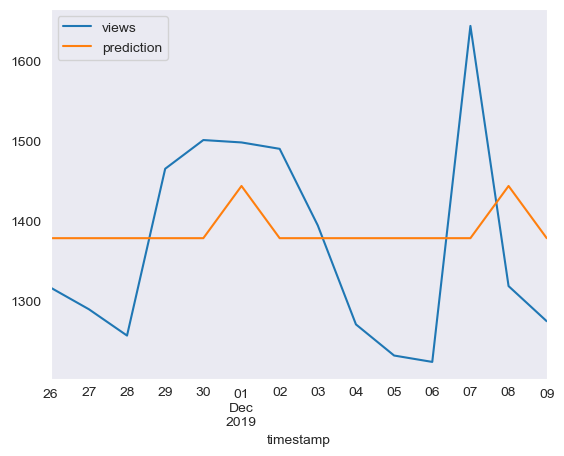

[0]	validation_0-rmse:1384.18522	validation_0-smape:1.97581	validation_1-rmse:809.40996	validation_1-smape:1.98100
[917]	validation_0-rmse:160.49298	validation_0-smape:0.07887	validation_1-rmse:303.17758	validation_1-smape:0.26849
Loss: 0.11710408901654715, Game: God of War II


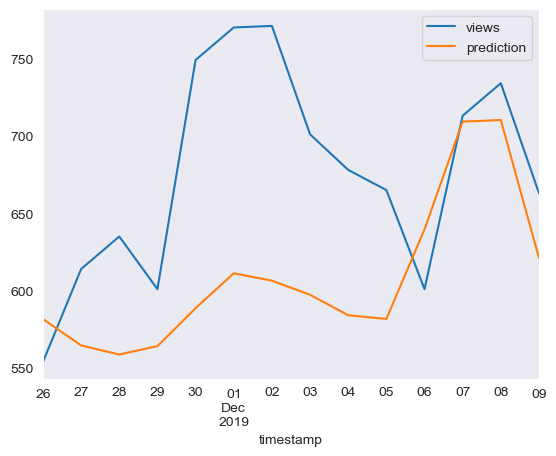

[0]	validation_0-rmse:2081.06999	validation_0-smape:1.97758	validation_1-rmse:1083.57536	validation_1-smape:1.98203
[1000]	validation_0-rmse:295.27720	validation_0-smape:0.07456	validation_1-rmse:369.20234	validation_1-smape:0.26787
[1079]	validation_0-rmse:269.62888	validation_0-smape:0.07209	validation_1-rmse:369.34864	validation_1-smape:0.26752
Loss: 0.1697417906583052, Game: God of War III


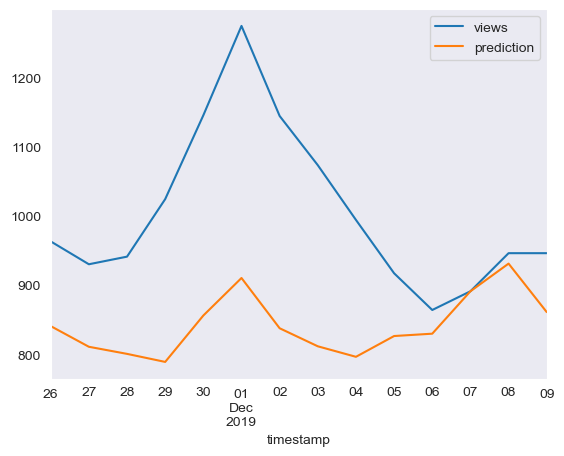

[0]	validation_0-rmse:245.35644	validation_0-smape:1.97129	validation_1-rmse:297.62949	validation_1-smape:1.97603
[1000]	validation_0-rmse:24.66476	validation_0-smape:0.07058	validation_1-rmse:120.85443	validation_1-smape:0.27236
[1630]	validation_0-rmse:21.69761	validation_0-smape:0.06382	validation_1-rmse:119.88176	validation_1-smape:0.26932
Loss: 0.06977940086797094, Game: Gran Turismo 4


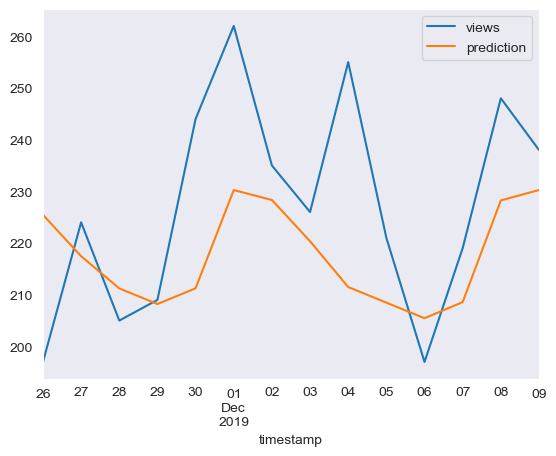

[0]	validation_0-rmse:1598.22894	validation_0-smape:1.97844	validation_1-rmse:1778.60758	validation_1-smape:1.98218
[1000]	validation_0-rmse:130.56693	validation_0-smape:0.04720	validation_1-rmse:658.07969	validation_1-smape:0.25298
[1280]	validation_0-rmse:101.73040	validation_0-smape:0.04284	validation_1-rmse:659.58170	validation_1-smape:0.24971
Loss: 0.16097309311027194, Game: Grand Theft Auto III


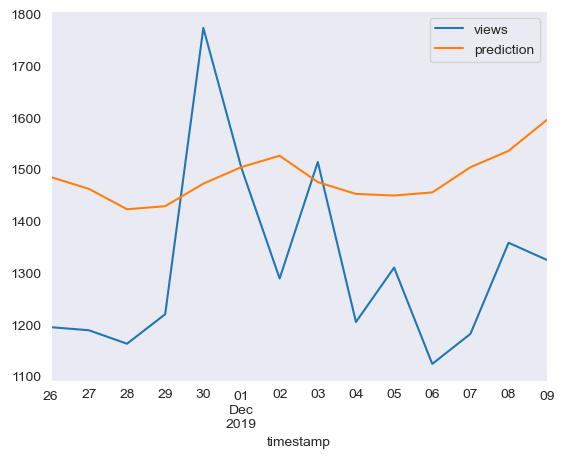

[0]	validation_0-rmse:2173.44988	validation_0-smape:1.97891	validation_1-rmse:2990.61184	validation_1-smape:1.98529
[1000]	validation_0-rmse:178.54476	validation_0-smape:0.04802	validation_1-rmse:1306.34726	validation_1-smape:0.37974
[1363]	validation_0-rmse:148.31933	validation_0-smape:0.04220	validation_1-rmse:1302.27845	validation_1-smape:0.37694
Loss: 0.09673424881572079, Game: Grand Theft Auto IV


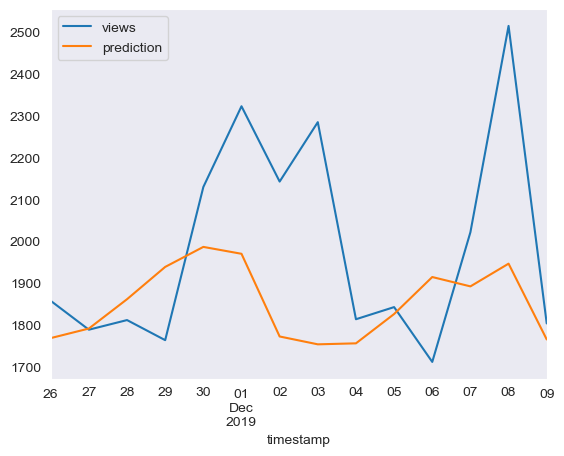

[0]	validation_0-rmse:7038.96649	validation_0-smape:1.97951	validation_1-rmse:9802.02202	validation_1-smape:1.98589
[1000]	validation_0-rmse:576.93041	validation_0-smape:0.04705	validation_1-rmse:4727.76665	validation_1-smape:0.38339
[1301]	validation_0-rmse:483.74897	validation_0-smape:0.04095	validation_1-rmse:4717.09734	validation_1-smape:0.38059
Loss: 0.07060146191548958, Game: Grand Theft Auto V


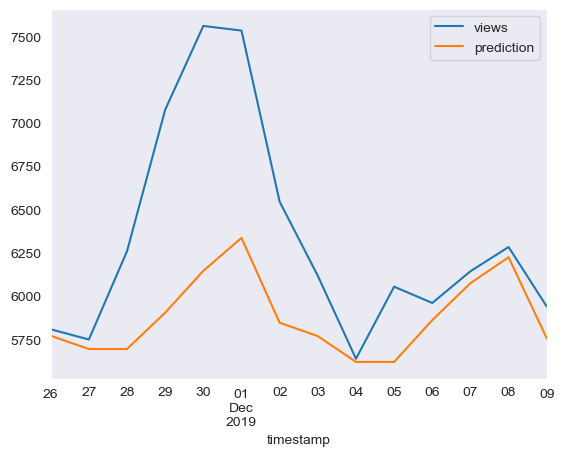

[0]	validation_0-rmse:961.95349	validation_0-smape:1.97774	validation_1-rmse:1091.95734	validation_1-smape:1.98057
[1000]	validation_0-rmse:67.57225	validation_0-smape:0.04773	validation_1-rmse:548.37214	validation_1-smape:0.17956
[1134]	validation_0-rmse:64.18304	validation_0-smape:0.04615	validation_1-rmse:547.93691	validation_1-smape:0.17892
Loss: 0.0843843912434163, Game: Guitar Hero


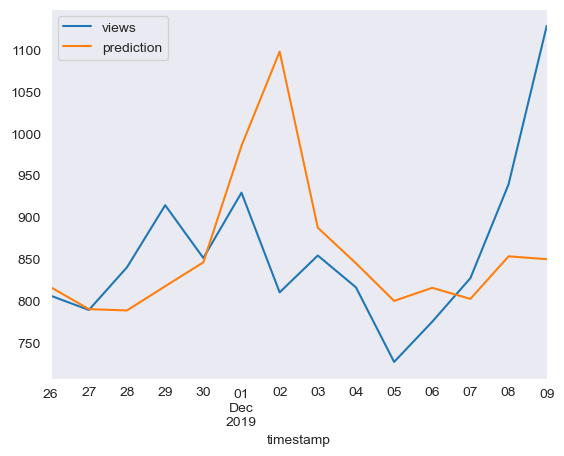

[0]	validation_0-rmse:1324.15840	validation_0-smape:1.97791	validation_1-rmse:1719.63842	validation_1-smape:1.96801
[839]	validation_0-rmse:178.86980	validation_0-smape:0.06877	validation_1-rmse:1781.28420	validation_1-smape:0.44944
Loss: 0.7299943444422963, Game: Half-Life 2


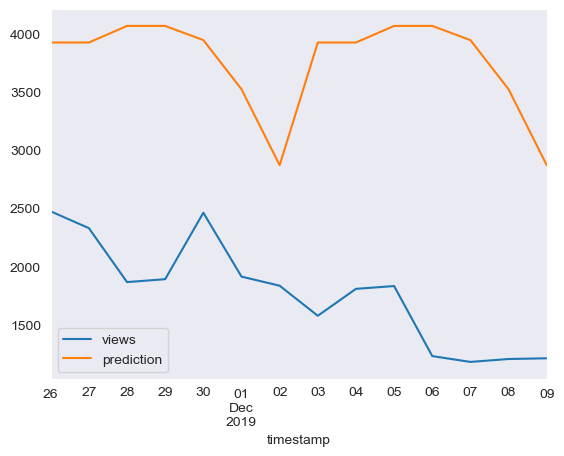

[0]	validation_0-rmse:784.79586	validation_0-smape:1.97700	validation_1-rmse:1135.40067	validation_1-smape:1.98312
[1000]	validation_0-rmse:76.30463	validation_0-smape:0.05627	validation_1-rmse:566.25150	validation_1-smape:0.38864
[1336]	validation_0-rmse:66.87103	validation_0-smape:0.05245	validation_1-rmse:568.55498	validation_1-smape:0.38657
Loss: 0.45674761483449317, Game: Halo 2


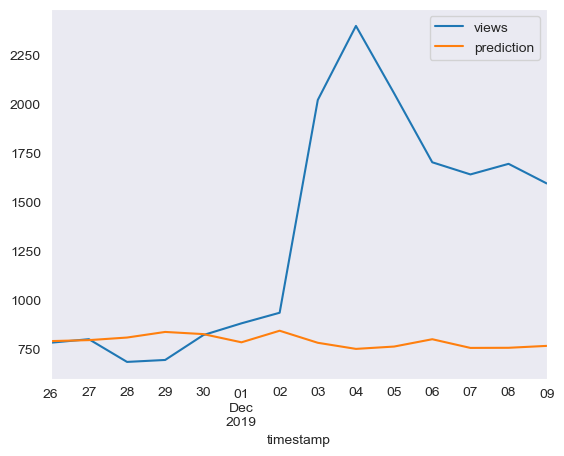

[0]	validation_0-rmse:946.19150	validation_0-smape:1.97700	validation_1-rmse:1260.01054	validation_1-smape:1.98013
[871]	validation_0-rmse:133.57362	validation_0-smape:0.07519	validation_1-rmse:1051.76503	validation_1-smape:0.35587
Loss: 0.4783967925895972, Game: Halo 3


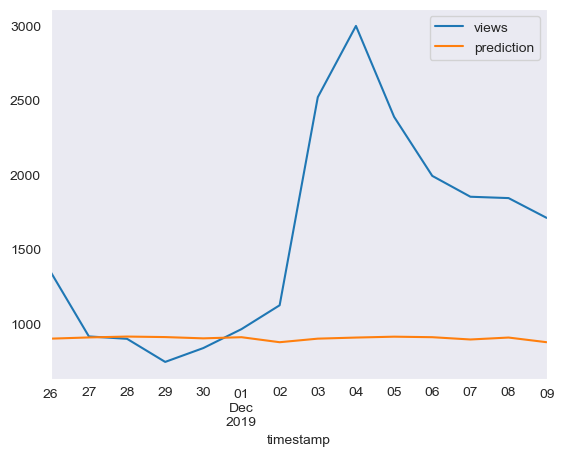

[0]	validation_0-rmse:1830.04004	validation_0-smape:1.97836	validation_1-rmse:1183.85066	validation_1-smape:1.96839
[440]	validation_0-rmse:377.50687	validation_0-smape:0.12456	validation_1-rmse:1019.37333	validation_1-smape:0.38092
Loss: 0.6030519604971254, Game: Heavy Rain


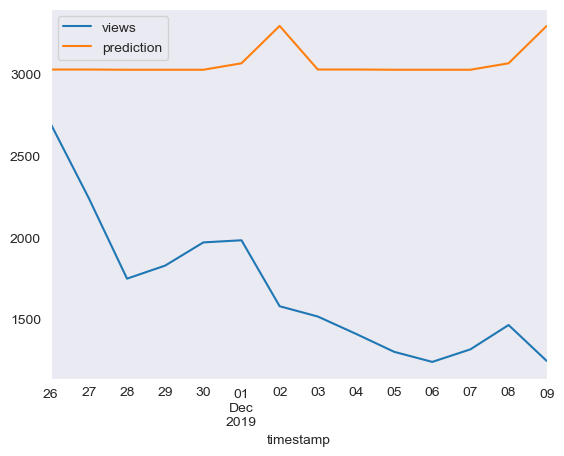

[0]	validation_0-rmse:730.24489	validation_0-smape:1.97673	validation_1-rmse:682.10264	validation_1-smape:1.97872
[1000]	validation_0-rmse:74.83133	validation_0-smape:0.07072	validation_1-rmse:167.01334	validation_1-smape:0.14759
[1182]	validation_0-rmse:69.87147	validation_0-smape:0.06735	validation_1-rmse:168.74151	validation_1-smape:0.14722
Loss: 0.08574884465214198, Game: Hotline Miami


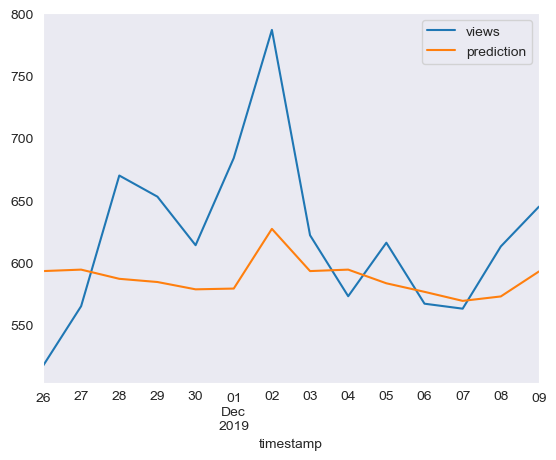

[0]	validation_0-rmse:904.10006	validation_0-smape:1.97623	validation_1-rmse:700.89452	validation_1-smape:1.98060
[970]	validation_0-rmse:122.18615	validation_0-smape:0.08625	validation_1-rmse:316.05992	validation_1-smape:0.31407
Loss: 0.11514043829522395, Game: Ico


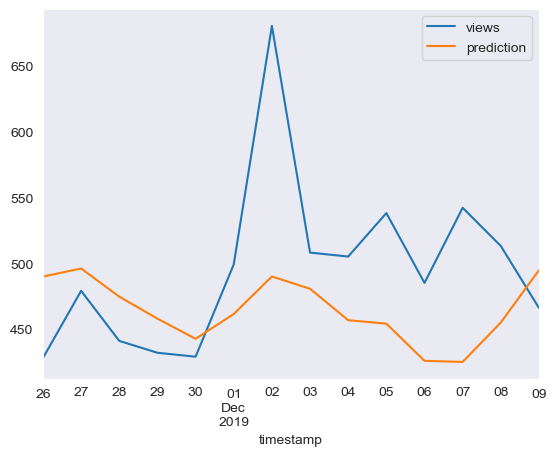

[0]	validation_0-rmse:210.97144	validation_0-smape:1.96903	validation_1-rmse:226.84735	validation_1-smape:1.97183
[780]	validation_0-rmse:36.52891	validation_0-smape:0.09912	validation_1-rmse:73.69374	validation_1-smape:0.22540
Loss: 0.4288157333102315, Game: Ikaruga


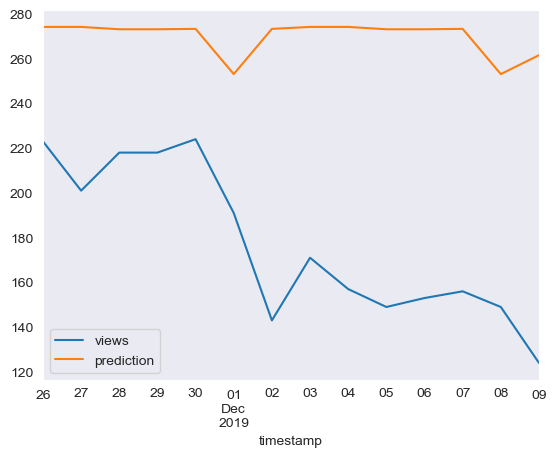

[0]	validation_0-rmse:432.13242	validation_0-smape:1.97427	validation_1-rmse:549.91570	validation_1-smape:1.98134
[1000]	validation_0-rmse:47.01836	validation_0-smape:0.07563	validation_1-rmse:245.03287	validation_1-smape:0.35047
[1336]	validation_0-rmse:41.11623	validation_0-smape:0.07026	validation_1-rmse:244.38331	validation_1-smape:0.34785
Loss: 0.2291947933223024, Game: Jet Set Radio


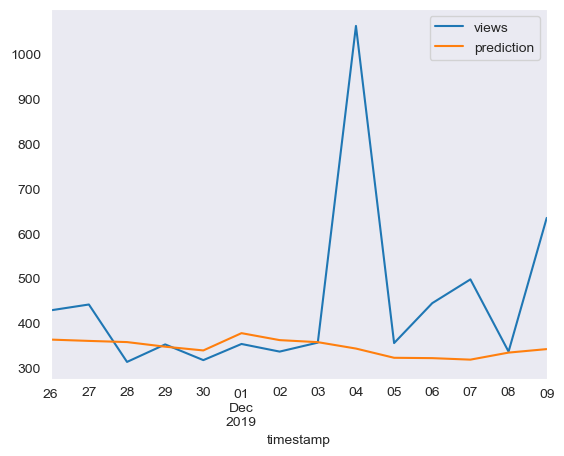

[0]	validation_0-rmse:644.51487	validation_0-smape:1.97554	validation_1-rmse:555.88213	validation_1-smape:1.96909
[615]	validation_0-rmse:146.09705	validation_0-smape:0.11122	validation_1-rmse:582.74046	validation_1-smape:0.31659
Loss: 0.6834940744575924, Game: Katamari Damacy


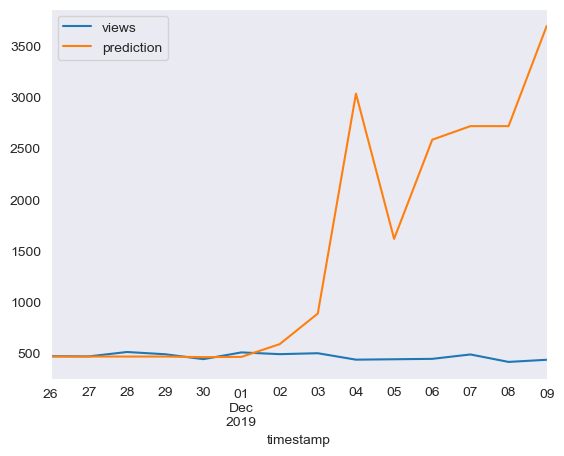

[0]	validation_0-rmse:4761.52517	validation_0-smape:1.97881	validation_1-rmse:2609.98394	validation_1-smape:1.96858
[713]	validation_0-rmse:771.33954	validation_0-smape:0.09187	validation_1-rmse:5207.46597	validation_1-smape:0.34318
Loss: 0.1554266612021693, Game: Kingdom Hearts


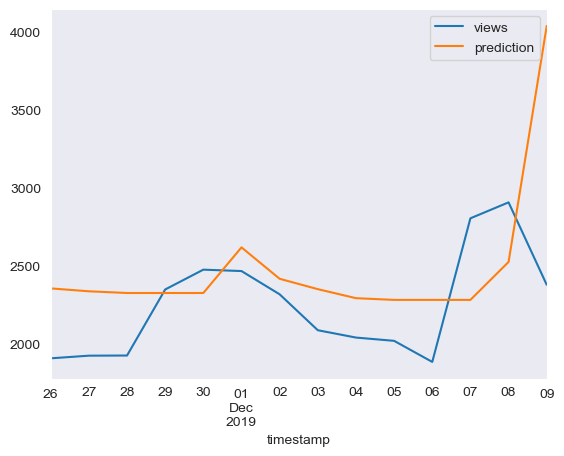

[0]	validation_0-rmse:3434.48245	validation_0-smape:1.97923	validation_1-rmse:4503.38917	validation_1-smape:1.98523
[1000]	validation_0-rmse:296.28413	validation_0-smape:0.05323	validation_1-rmse:1929.88680	validation_1-smape:0.33567
[1395]	validation_0-rmse:257.09650	validation_0-smape:0.04945	validation_1-rmse:1921.45826	validation_1-smape:0.33009
Loss: 0.13333534709846978, Game: League of Legends


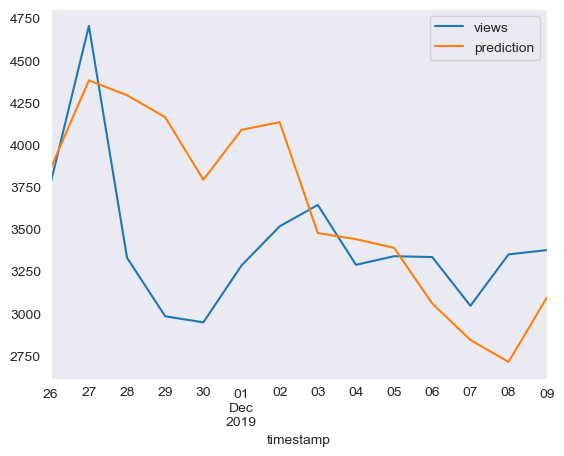

[0]	validation_0-rmse:711.99534	validation_0-smape:1.97674	validation_1-rmse:1091.08513	validation_1-smape:1.98275
[1000]	validation_0-rmse:79.24913	validation_0-smape:0.06826	validation_1-rmse:612.52473	validation_1-smape:0.37000
[1242]	validation_0-rmse:71.47207	validation_0-smape:0.06383	validation_1-rmse:610.35971	validation_1-smape:0.36790
Loss: 0.11238453260779775, Game: Left 4 Dead 2


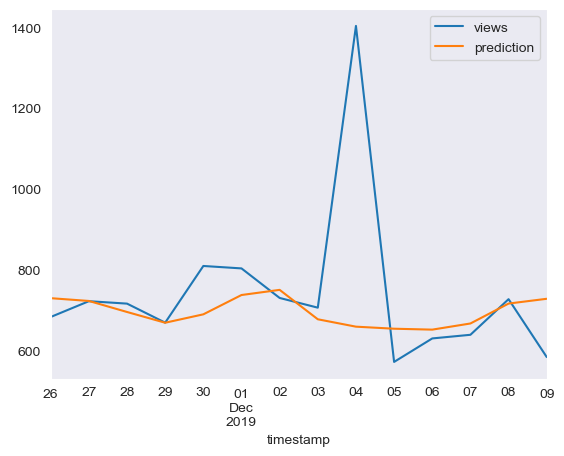

[0]	validation_0-rmse:790.80076	validation_0-smape:1.97717	validation_1-rmse:995.64142	validation_1-smape:1.97855
[1000]	validation_0-rmse:70.24829	validation_0-smape:0.06298	validation_1-rmse:516.38804	validation_1-smape:0.22055
[1001]	validation_0-rmse:70.22340	validation_0-smape:0.06296	validation_1-rmse:516.38279	validation_1-smape:0.22053
Loss: 0.08887165884785884, Game: Left 4 Dead


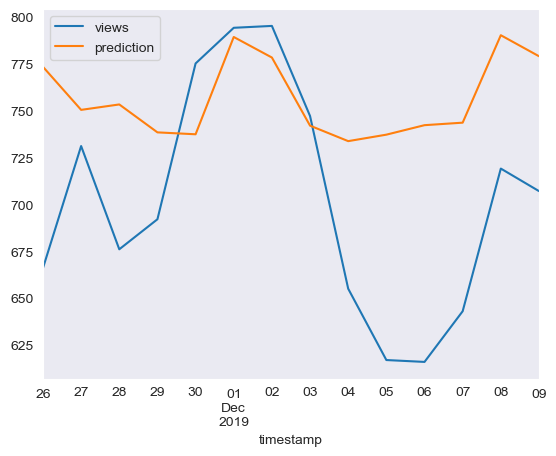

[0]	validation_0-rmse:1090.75947	validation_0-smape:1.97802	validation_1-rmse:981.57172	validation_1-smape:1.97988
[1000]	validation_0-rmse:75.71627	validation_0-smape:0.04666	validation_1-rmse:178.99947	validation_1-smape:0.14082
[1345]	validation_0-rmse:69.02757	validation_0-smape:0.04371	validation_1-rmse:177.82650	validation_1-smape:0.13863
Loss: 0.06263338549812468, Game: Limbo


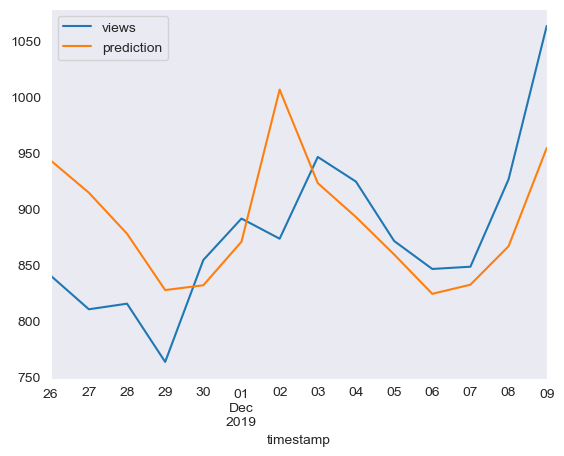

[0]	validation_0-rmse:452.63262	validation_0-smape:1.97503	validation_1-rmse:721.47937	validation_1-smape:1.98241
[1000]	validation_0-rmse:57.91805	validation_0-smape:0.06746	validation_1-rmse:415.18661	validation_1-smape:0.37663
[1138]	validation_0-rmse:54.68307	validation_0-smape:0.06522	validation_1-rmse:415.73074	validation_1-smape:0.37557
Loss: 0.12036086559074502, Game: LittleBigPlanet


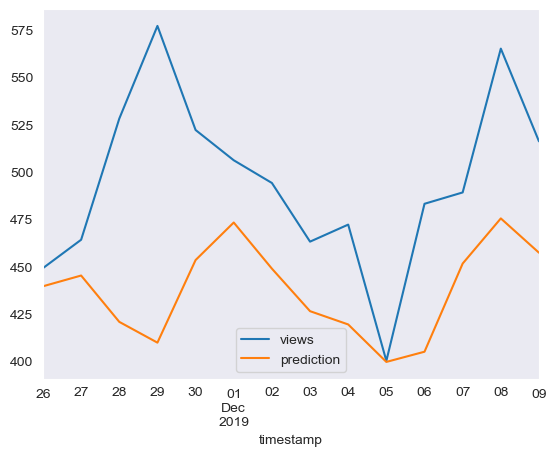

[0]	validation_0-rmse:1015.74140	validation_0-smape:1.97647	validation_1-rmse:601.43275	validation_1-smape:1.97935
[1000]	validation_0-rmse:88.29529	validation_0-smape:0.06280	validation_1-rmse:170.57586	validation_1-smape:0.19267
[1087]	validation_0-rmse:79.35061	validation_0-smape:0.06177	validation_1-rmse:170.15595	validation_1-smape:0.19205
Loss: 0.06337917267634371, Game: Mass Effect 2


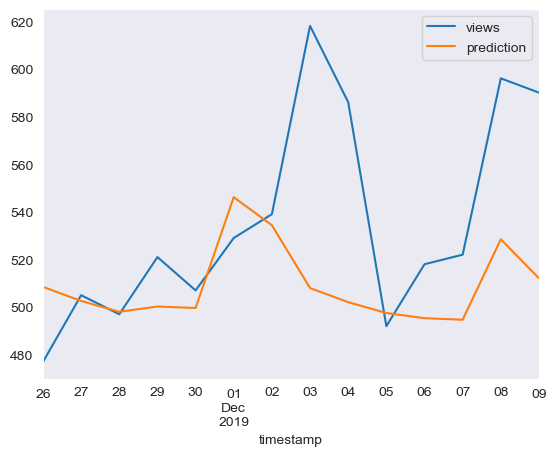

[0]	validation_0-rmse:1964.38992	validation_0-smape:1.97865	validation_1-rmse:1739.87820	validation_1-smape:1.98087
[1000]	validation_0-rmse:159.74425	validation_0-smape:0.05453	validation_1-rmse:883.68265	validation_1-smape:0.22134
[1237]	validation_0-rmse:145.03616	validation_0-smape:0.05139	validation_1-rmse:883.30600	validation_1-smape:0.22078
Loss: 0.04776129058068427, Game: Mass Effect


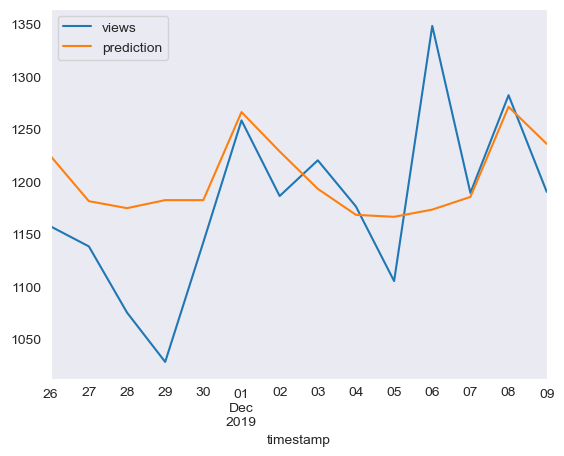

[0]	validation_0-rmse:775.48328	validation_0-smape:1.97673	validation_1-rmse:775.35684	validation_1-smape:1.98024
[1000]	validation_0-rmse:122.91423	validation_0-smape:0.09744	validation_1-rmse:253.70476	validation_1-smape:0.24247
[1183]	validation_0-rmse:117.12695	validation_0-smape:0.09443	validation_1-rmse:253.41787	validation_1-smape:0.24166
Loss: 0.07935661063089924, Game: Max Payne


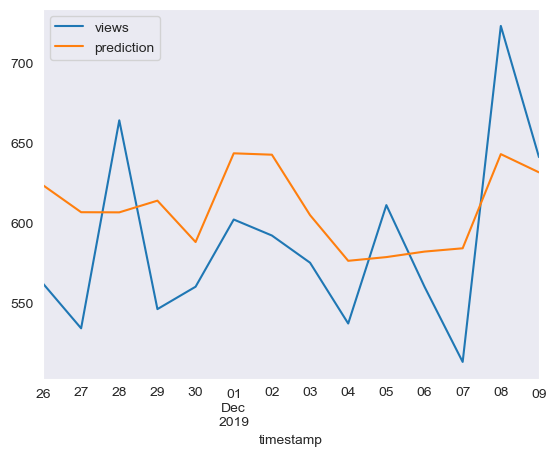

[0]	validation_0-rmse:751.00510	validation_0-smape:1.97562	validation_1-rmse:555.17375	validation_1-smape:1.97679
[903]	validation_0-rmse:118.05587	validation_0-smape:0.08201	validation_1-rmse:445.18392	validation_1-smape:0.26816
Loss: 0.2895593887302542, Game: Metroid Prime


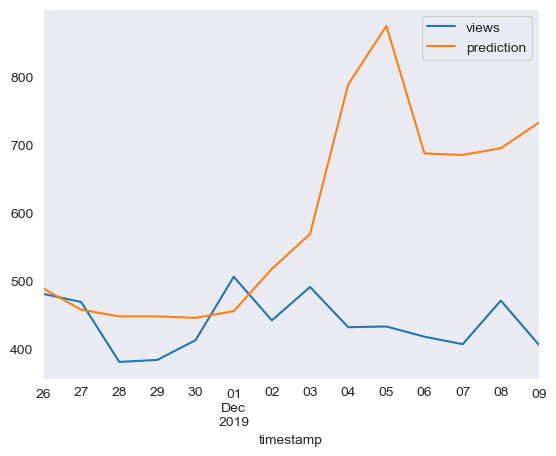

[0]	validation_0-rmse:7234.55785	validation_0-smape:1.97972	validation_1-rmse:14553.30333	validation_1-smape:1.98838
[1000]	validation_0-rmse:506.82656	validation_0-smape:0.04474	validation_1-rmse:7117.01267	validation_1-smape:0.58189
[2000]	validation_0-rmse:354.48660	validation_0-smape:0.03431	validation_1-rmse:7061.68424	validation_1-smape:0.57482
[2461]	validation_0-rmse:320.09093	validation_0-smape:0.03155	validation_1-rmse:7058.49687	validation_1-smape:0.57439
Loss: 0.033279844980051584, Game: Minecraft


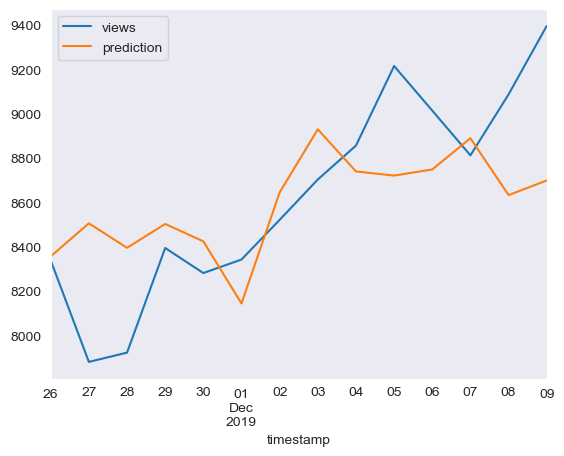

[0]	validation_0-rmse:376.94349	validation_0-smape:1.96872	validation_1-rmse:93.60103	validation_1-smape:1.95061
[347]	validation_0-rmse:120.02484	validation_0-smape:0.18822	validation_1-rmse:28.71667	validation_1-smape:0.19723
Loss: 0.23349075522537185, Game: Overwatch


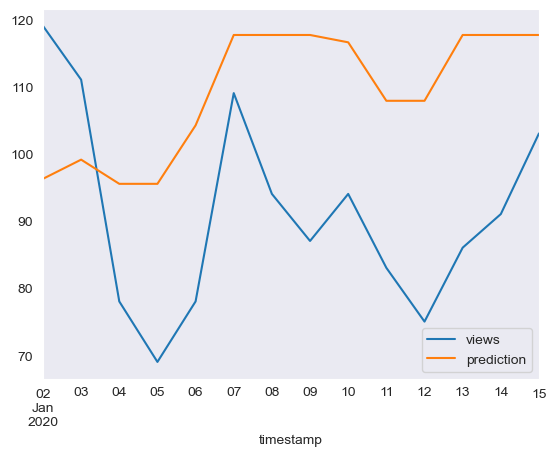

[0]	validation_0-rmse:714.94910	validation_0-smape:1.97570	validation_1-rmse:689.95153	validation_1-smape:1.97419
[743]	validation_0-rmse:160.80670	validation_0-smape:0.11751	validation_1-rmse:402.69775	validation_1-smape:0.22535
Loss: 0.414466974546521, Game: Papers, Please


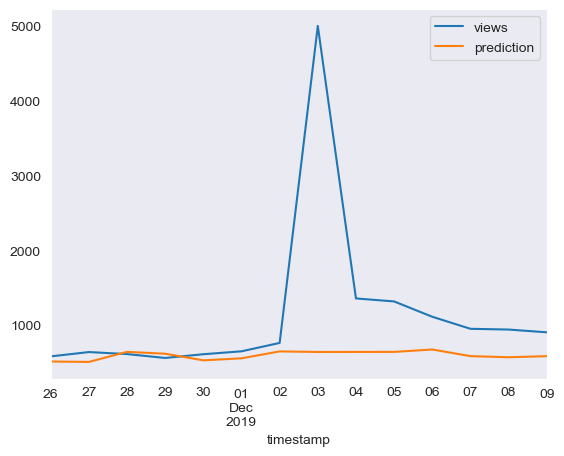

[0]	validation_0-rmse:918.58943	validation_0-smape:1.96728	validation_1-rmse:2214.55123	validation_1-smape:1.98257
[1000]	validation_0-rmse:120.82096	validation_0-smape:0.16467	validation_1-rmse:1678.64469	validation_1-smape:0.35665
[1348]	validation_0-rmse:97.94801	validation_0-smape:0.15027	validation_1-rmse:1676.69829	validation_1-smape:0.35304
Loss: 0.1499735530156896, Game: Persona 4


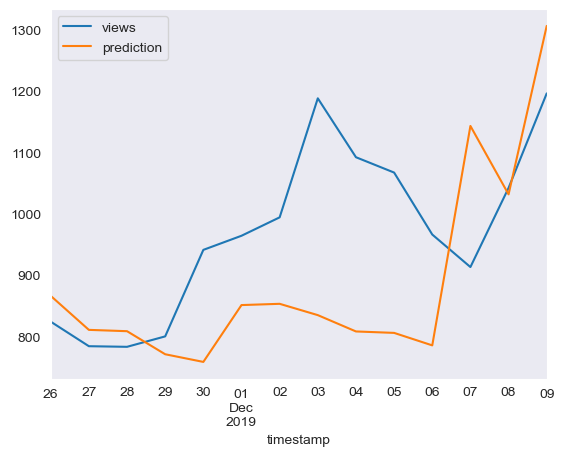

[0]	validation_0-rmse:1961.42178	validation_0-smape:1.97744	validation_1-rmse:1082.57000	validation_1-smape:1.97987
[1000]	validation_0-rmse:160.19494	validation_0-smape:0.05666	validation_1-rmse:245.14042	validation_1-smape:0.17429
[1163]	validation_0-rmse:116.02085	validation_0-smape:0.05420	validation_1-rmse:245.01935	validation_1-smape:0.17372
Loss: 0.11492384492107537, Game: Plants vs. Zombies


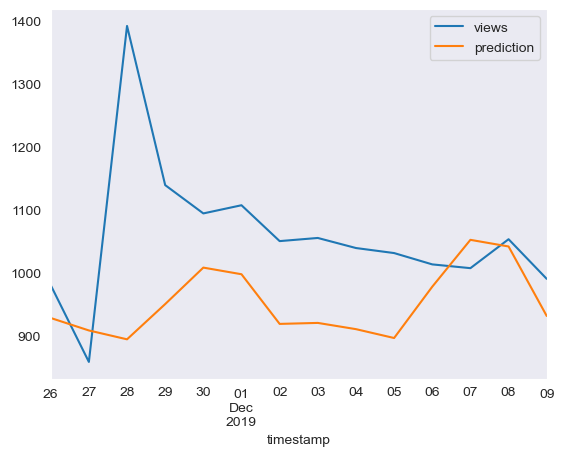

[0]	validation_0-rmse:1577.76347	validation_0-smape:1.97752	validation_1-rmse:1110.82520	validation_1-smape:1.98087
[1000]	validation_0-rmse:201.69125	validation_0-smape:0.07403	validation_1-rmse:349.03268	validation_1-smape:0.19408
[1227]	validation_0-rmse:170.96784	validation_0-smape:0.06959	validation_1-rmse:348.57396	validation_1-smape:0.19329
Loss: 0.0912280447675292, Game: Portal 2


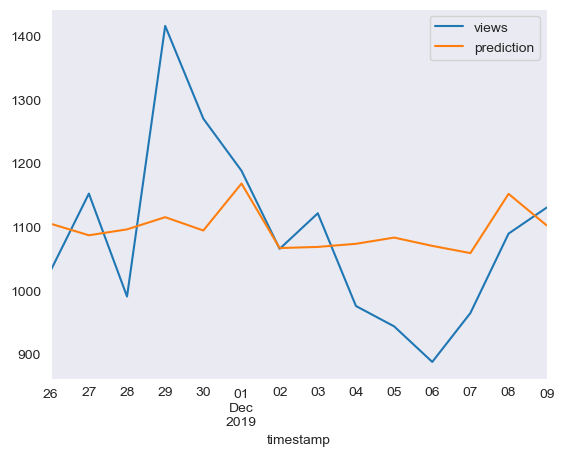

[0]	validation_0-rmse:654.20978	validation_0-smape:1.97449	validation_1-rmse:522.10001	validation_1-smape:1.97440
[781]	validation_0-rmse:131.01793	validation_0-smape:0.10959	validation_1-rmse:458.44358	validation_1-smape:0.29693
Loss: 0.4829626756126017, Game: Psychonauts


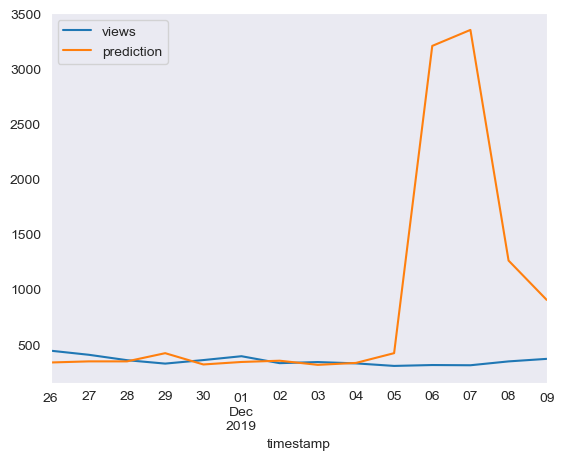

[0]	validation_0-rmse:22612.57333	validation_0-smape:1.97893	validation_1-rmse:5999.92489	validation_1-smape:1.97719
[520]	validation_0-rmse:3698.47061	validation_0-smape:0.13053	validation_1-rmse:1910.89786	validation_1-smape:0.18017
Loss: 0.10297266522213278, Game: Red Dead Redemption 2


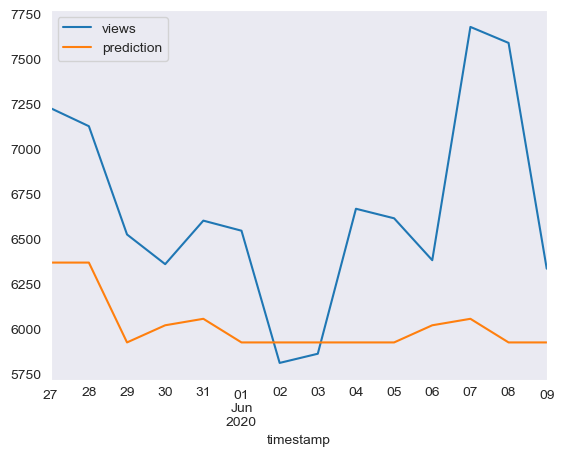

[0]	validation_0-rmse:8640.07059	validation_0-smape:1.97847	validation_1-rmse:3380.51624	validation_1-smape:1.97662
[1000]	validation_0-rmse:758.76301	validation_0-smape:0.09558	validation_1-rmse:2218.83088	validation_1-smape:0.31079
[1063]	validation_0-rmse:721.43100	validation_0-smape:0.09325	validation_1-rmse:2233.91398	validation_1-smape:0.31108
Loss: 0.06315841910514401, Game: Red Dead Redemption


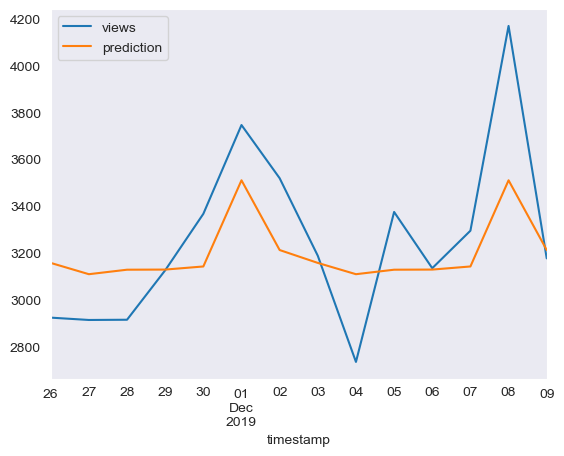

[0]	validation_0-rmse:1792.92724	validation_0-smape:1.97841	validation_1-rmse:2176.20071	validation_1-smape:1.97897
[1000]	validation_0-rmse:192.58636	validation_0-smape:0.06880	validation_1-rmse:1594.03863	validation_1-smape:0.34906
[1320]	validation_0-rmse:163.79638	validation_0-smape:0.06080	validation_1-rmse:1601.74050	validation_1-smape:0.34704
Loss: 0.09456881829037686, Game: Resident Evil 4


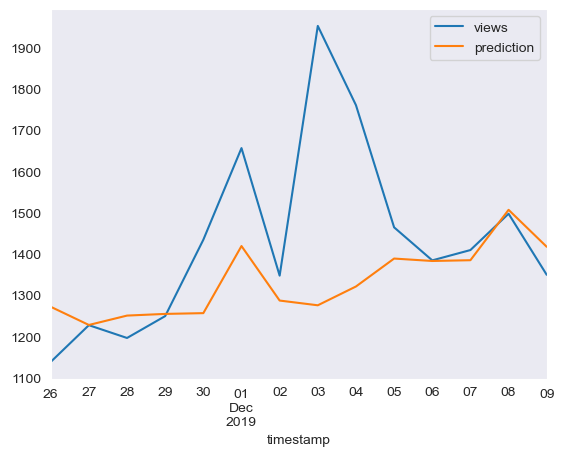

[0]	validation_0-rmse:169.78294	validation_0-smape:1.96745	validation_1-rmse:141.99185	validation_1-smape:1.96630
[1000]	validation_0-rmse:16.58195	validation_0-smape:0.07574	validation_1-rmse:33.82248	validation_1-smape:0.16725
[1020]	validation_0-rmse:16.52017	validation_0-smape:0.07550	validation_1-rmse:33.92065	validation_1-smape:0.16736
Loss: 0.22349091863888954, Game: Rock Band 2


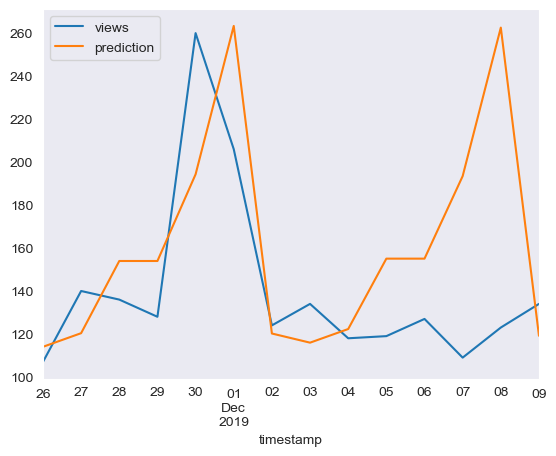

[0]	validation_0-rmse:228.35780	validation_0-smape:1.97009	validation_1-rmse:206.39036	validation_1-smape:1.97268
[1000]	validation_0-rmse:25.05238	validation_0-smape:0.07421	validation_1-rmse:63.41834	validation_1-smape:0.20721
[1159]	validation_0-rmse:23.84006	validation_0-smape:0.07175	validation_1-rmse:63.40088	validation_1-smape:0.20711
Loss: 0.14937376822511142, Game: Rock Band 3


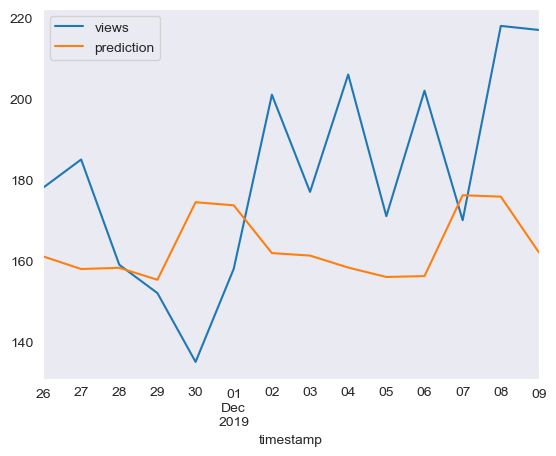

[0]	validation_0-rmse:421.91885	validation_0-smape:1.97496	validation_1-rmse:486.68964	validation_1-smape:1.97743
[1000]	validation_0-rmse:40.20299	validation_0-smape:0.06450	validation_1-rmse:209.23875	validation_1-smape:0.18236
[1125]	validation_0-rmse:38.61906	validation_0-smape:0.06266	validation_1-rmse:209.24970	validation_1-smape:0.18225
Loss: 0.0960936599236731, Game: Rock Band


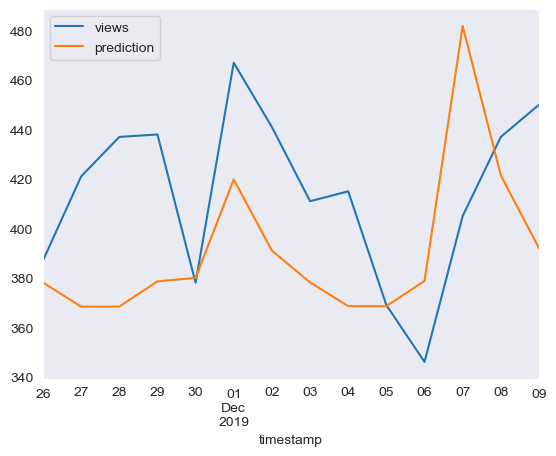

[0]	validation_0-rmse:2054.92999	validation_0-smape:1.97813	validation_1-rmse:1649.53157	validation_1-smape:1.98323
[1000]	validation_0-rmse:181.67827	validation_0-smape:0.07481	validation_1-rmse:981.32548	validation_1-smape:0.36596
[1214]	validation_0-rmse:165.23363	validation_0-smape:0.07105	validation_1-rmse:980.16805	validation_1-smape:0.36513
Loss: 0.2701111147565354, Game: Rocket League


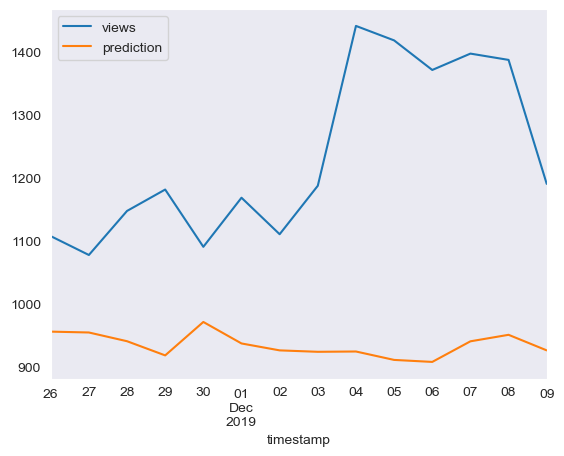

[0]	validation_0-rmse:2440.45963	validation_0-smape:1.97747	validation_1-rmse:1818.68786	validation_1-smape:1.98071
[781]	validation_0-rmse:523.39510	validation_0-smape:0.11922	validation_1-rmse:1209.86469	validation_1-smape:0.37971
Loss: 0.06772030127592497, Game: Shadow of the Colossus


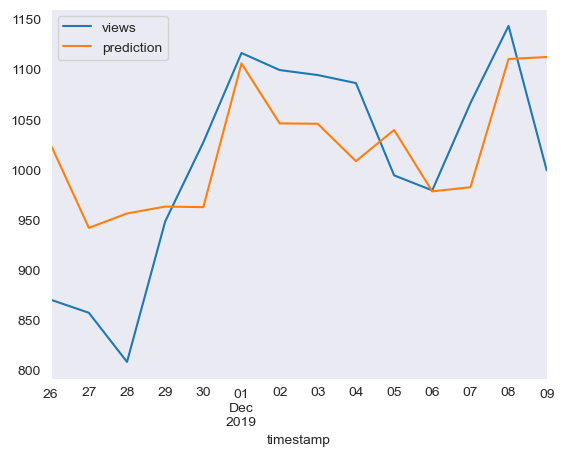

[0]	validation_0-rmse:794.10162	validation_0-smape:1.97643	validation_1-rmse:629.07056	validation_1-smape:1.97613
[757]	validation_0-rmse:114.81389	validation_0-smape:0.08443	validation_1-rmse:272.51159	validation_1-smape:0.20010
Loss: 0.45086043505548207, Game: Shovel Knight


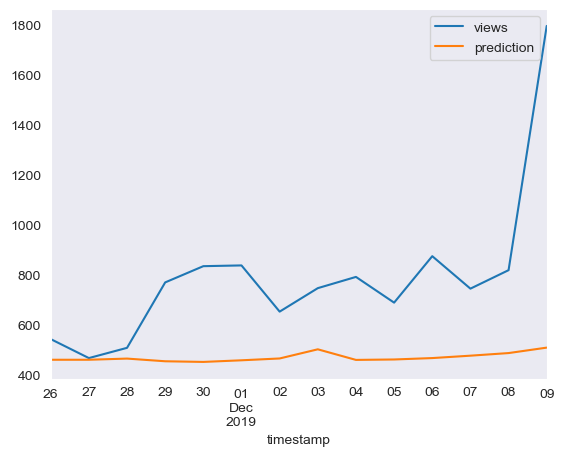

[0]	validation_0-rmse:794.19458	validation_0-smape:1.97697	validation_1-rmse:1014.15269	validation_1-smape:1.98210
[1000]	validation_0-rmse:97.64848	validation_0-smape:0.07780	validation_1-rmse:377.86347	validation_1-smape:0.29173
[1141]	validation_0-rmse:93.04060	validation_0-smape:0.07545	validation_1-rmse:377.05112	validation_1-smape:0.29096
Loss: 0.08539342778874238, Game: Silent Hill 2


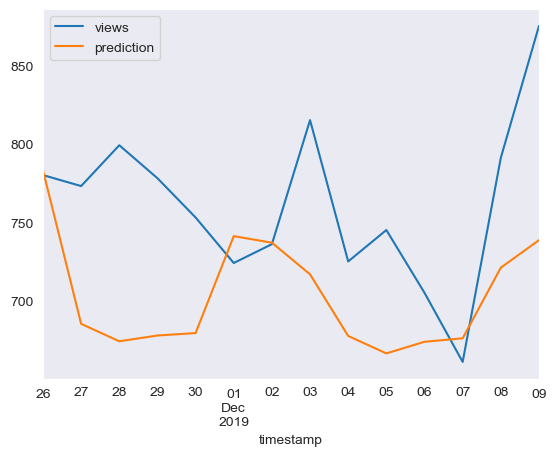

[0]	validation_0-rmse:283.92545	validation_0-smape:1.97165	validation_1-rmse:262.61285	validation_1-smape:1.97535
[1000]	validation_0-rmse:33.94750	validation_0-smape:0.08099	validation_1-rmse:68.32551	validation_1-smape:0.20223
[1289]	validation_0-rmse:30.71633	validation_0-smape:0.07522	validation_1-rmse:67.55175	validation_1-smape:0.19945
Loss: 0.1506610376167914, Game: Soulcalibur II


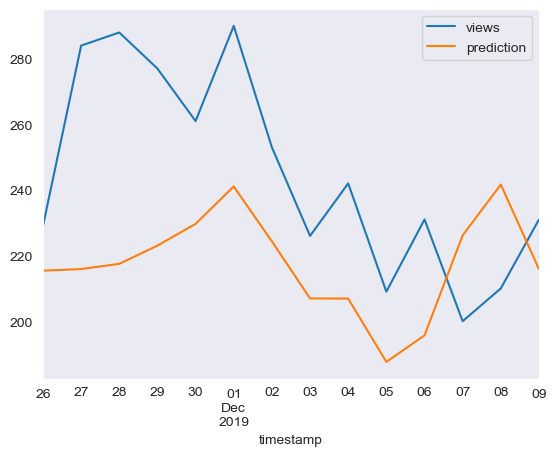

[0]	validation_0-rmse:270.69322	validation_0-smape:1.97071	validation_1-rmse:484.12788	validation_1-smape:1.97896
[1000]	validation_0-rmse:42.53704	validation_0-smape:0.09876	validation_1-rmse:351.30915	validation_1-smape:0.39349
[1140]	validation_0-rmse:39.51701	validation_0-smape:0.09465	validation_1-rmse:351.28584	validation_1-smape:0.39376
Loss: 0.17389595879535474, Game: Spelunky


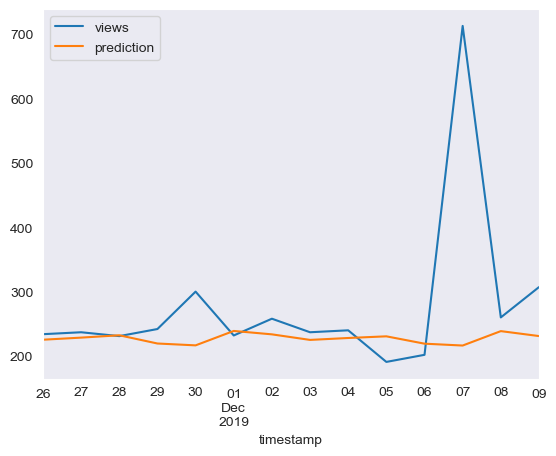

[0]	validation_0-rmse:1924.88213	validation_0-smape:1.96712	validation_1-rmse:2296.52138	validation_1-smape:1.98087
[946]	validation_0-rmse:331.38200	validation_0-smape:0.13173	validation_1-rmse:1215.30627	validation_1-smape:0.21200
Loss: 0.05572308288644345, Game: Stardew Valley


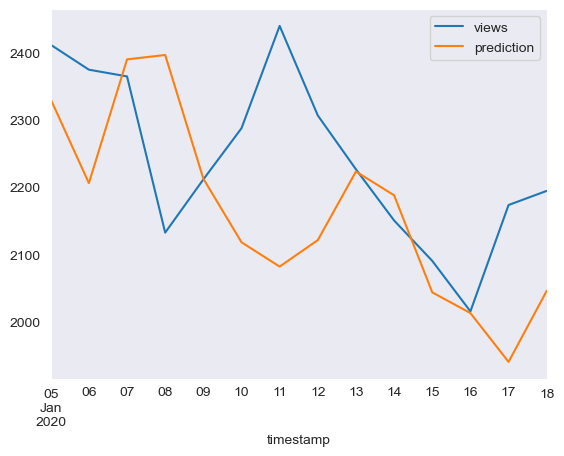

[0]	validation_0-rmse:576.82230	validation_0-smape:1.97556	validation_1-rmse:410.14893	validation_1-smape:1.97754
[1000]	validation_0-rmse:47.71445	validation_0-smape:0.06009	validation_1-rmse:102.56777	validation_1-smape:0.18332
[1127]	validation_0-rmse:44.38408	validation_0-smape:0.05787	validation_1-rmse:102.21605	validation_1-smape:0.18299
Loss: 0.08688470086037971, Game: Street Fighter IV


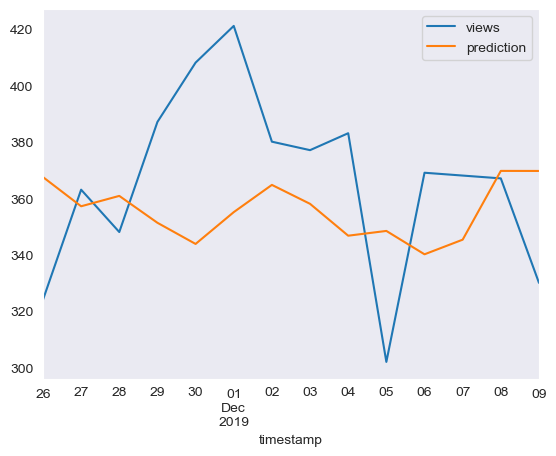

[0]	validation_0-rmse:377.80893	validation_0-smape:1.97386	validation_1-rmse:666.60778	validation_1-smape:1.98012
[1000]	validation_0-rmse:36.83626	validation_0-smape:0.06725	validation_1-rmse:484.62565	validation_1-smape:0.40067
[1449]	validation_0-rmse:31.01889	validation_0-smape:0.06094	validation_1-rmse:483.61267	validation_1-smape:0.39946
Loss: 0.21948587908932193, Game: Super Mario Galaxy 2


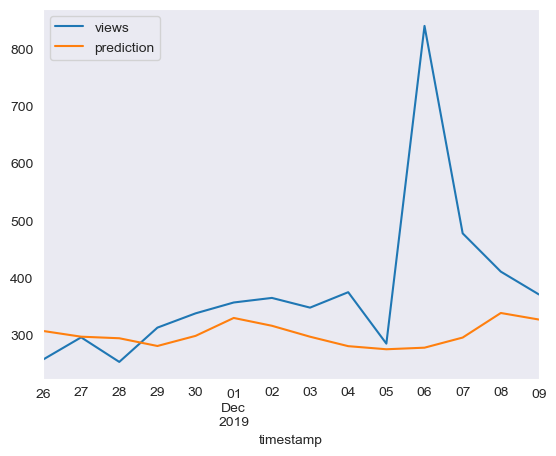

[0]	validation_0-rmse:1203.09682	validation_0-smape:1.97637	validation_1-rmse:1166.78962	validation_1-smape:1.98121
[1000]	validation_0-rmse:109.90644	validation_0-smape:0.07235	validation_1-rmse:779.96760	validation_1-smape:0.34712
[1480]	validation_0-rmse:64.43695	validation_0-smape:0.06232	validation_1-rmse:777.34438	validation_1-smape:0.34355
Loss: 0.062028006428467154, Game: Super Mario Galaxy


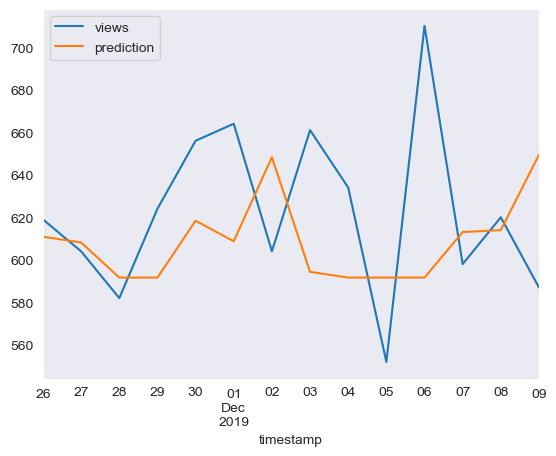

[0]	validation_0-rmse:4128.51863	validation_0-smape:1.97886	validation_1-rmse:1557.13061	validation_1-smape:1.98304
[1000]	validation_0-rmse:281.79692	validation_0-smape:0.05206	validation_1-rmse:379.18246	validation_1-smape:0.19200
[1134]	validation_0-rmse:237.79906	validation_0-smape:0.04819	validation_1-rmse:376.68791	validation_1-smape:0.19112
Loss: 0.3553861793532679, Game: Super Mario Odyssey


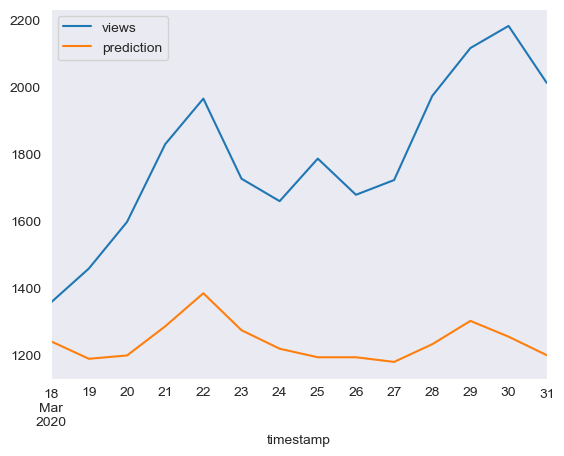

[0]	validation_0-rmse:1128.26170	validation_0-smape:1.97530	validation_1-rmse:416.98401	validation_1-smape:1.97432
[983]	validation_0-rmse:108.72839	validation_0-smape:0.07713	validation_1-rmse:154.05923	validation_1-smape:0.17723
Loss: 0.13753912604106236, Game: Super Meat Boy


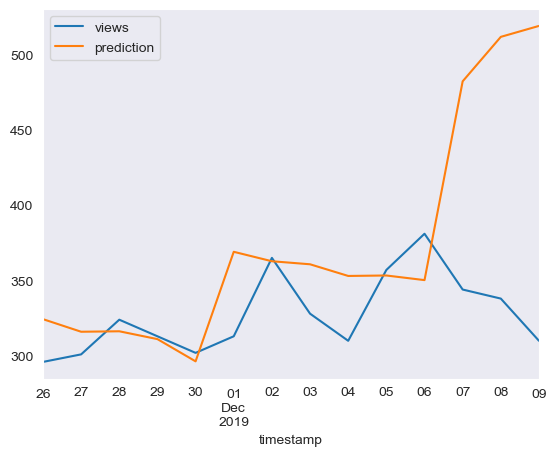

[0]	validation_0-rmse:4036.88462	validation_0-smape:1.97674	validation_1-rmse:594.54359	validation_1-smape:1.97026
[542]	validation_0-rmse:1031.76438	validation_0-smape:0.09654	validation_1-rmse:439.65318	validation_1-smape:0.28154
Loss: 0.5644943346630038, Game: Super Smash Bros. Melee


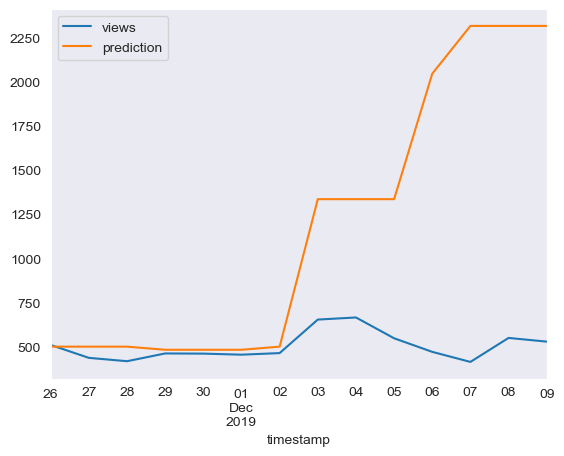

[0]	validation_0-rmse:1030.28840	validation_0-smape:1.97756	validation_1-rmse:1182.54067	validation_1-smape:1.98299
[1000]	validation_0-rmse:108.24112	validation_0-smape:0.05446	validation_1-rmse:533.56040	validation_1-smape:0.32794
[1407]	validation_0-rmse:91.11920	validation_0-smape:0.04990	validation_1-rmse:531.90000	validation_1-smape:0.32541
Loss: 0.06709844299473429, Game: Team Fortress 2


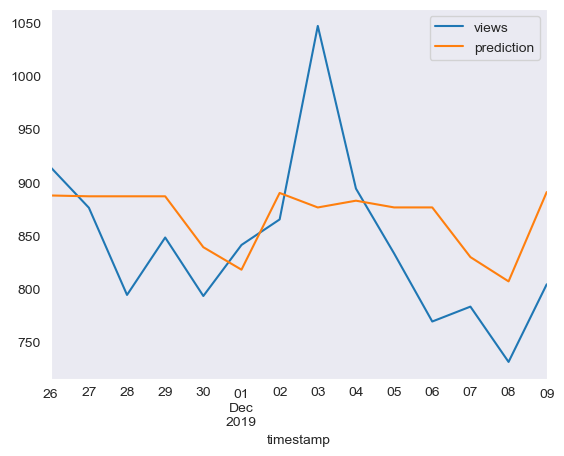

[0]	validation_0-rmse:6220.35156	validation_0-smape:1.97920	validation_1-rmse:14096.53007	validation_1-smape:1.98551
[870]	validation_0-rmse:1017.37930	validation_0-smape:0.06848	validation_1-rmse:12668.22315	validation_1-smape:0.62590
Loss: 0.09155004482664904, Game: The Last of Us


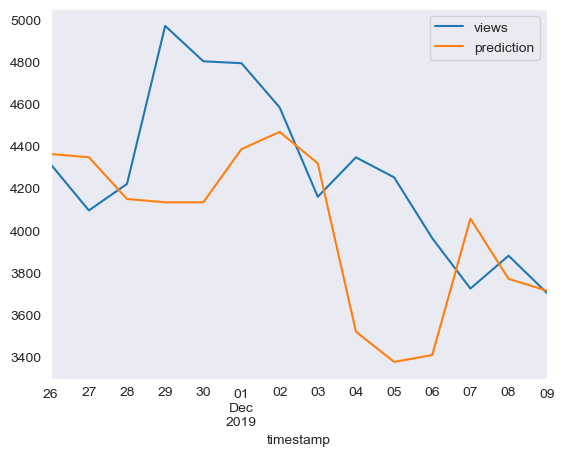

[0]	validation_0-rmse:705.38686	validation_0-smape:1.97696	validation_1-rmse:677.34611	validation_1-smape:1.97665
[652]	validation_0-rmse:70.79804	validation_0-smape:0.06955	validation_1-rmse:195.29740	validation_1-smape:0.18299
Loss: 0.10272159850826286, Game: The Sims 2


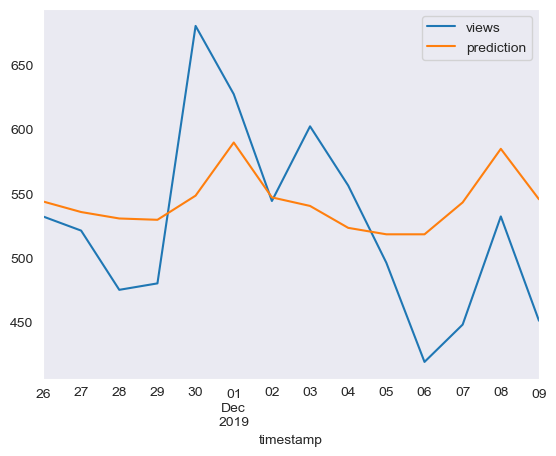

[17:55:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:1517: Empty dataset at worker: 0
[17:55:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:1517: Empty dataset at worker: 0
[17:55:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:1517: Empty dataset at worker: 0
[17:55:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:1517: Empty dataset at worker: 0
[17:55:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:1517: Empty dataset at worker: 0
[17:55:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group

C:\Users\Tobias\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Tobias\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: no numeric data to plot

In [71]:
for file in get_fileNames("Games"):
    model = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.005, eval_metric=smape)

    df = make_data("Games", file)
    train_data, test_data = split_train_test(df, 0.2)

    train_data = create_features(train_data)
    test_data = create_features(test_data)

    X_train = train_data[FEATURES]
    y_train = train_data[TARGET]

    X_test = test_data[FEATURES]
    y_test = test_data[TARGET]

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1000)

    df = make_data("Games", file)
    _, test_data = split_train_test(df, 0.2)

    test_data = create_features(test_data)

    X_test = test_data[FEATURES]
    y_test = test_data[TARGET]

    test_data["prediction"] = model.predict(X_test)

    test_data = test_data.head(14)

    test_data["views"].plot()
    test_data["prediction"].plot()
    loss = smape(test_data["views"], test_data["prediction"])
    print(f"Loss: {loss}, Game: {file}")
    plt.legend()
    plt.grid()
    plt.show()

<AxesSubplot:>

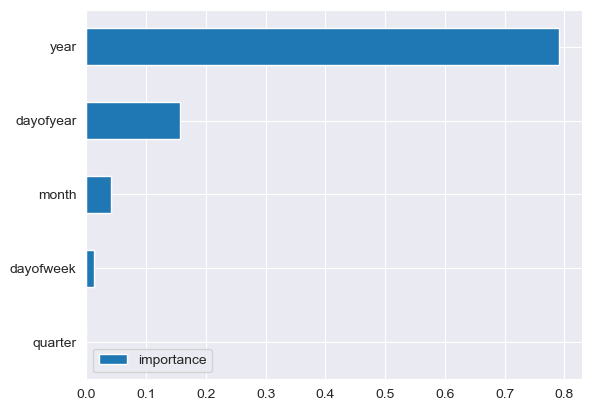

In [67]:
fi = pd.DataFrame(data=model.feature_importances_,
                  index=model.feature_names_in_,
                  columns=["importance"])
fi.sort_values("importance").plot(kind="barh")

# Mehr Daten

In [ ]:
most_common_propn("Minecraft", 5)